1. SmartLeafNet (EfficientNetB0 + ResNet50)

In [4]:
import os
import numpy as np
import tensorflow as tf
import gc
import optuna
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Paths
train_dir = r"C:\Users\PRATHESWARAN H\Desktop\Ajmal\Augumented leaf detection\train"
valid_dir = r"C:\Users\PRATHESWARAN H\Desktop\Ajmal\Augumented leaf detection\valid"

# Config
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 8
EPOCHS = 50

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_generator.class_indices)
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
train_labels = train_generator.classes

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

# Callbacks
early_stopping = EarlyStopping(monitor="val_accuracy", patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)

# Model Training

def build_model(base_model_class, name):
    print(f"\n🔧 Training {name} for {EPOCHS} epochs...")
    base_model = base_model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs=base_model.input, outputs=out, name=name)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=EPOCHS,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weights,
        verbose=1
    )

    return model

# Feature Extraction

def extract_features(model):
    feature_model = Model(inputs=model.input, outputs=model.layers[-3].output)
    train_features = feature_model.predict(train_generator, verbose=1)
    valid_features = feature_model.predict(valid_generator, verbose=1)
    return train_features, valid_features

# Train and extract features from both models
all_train_feats, all_valid_feats = [], []
for base_model_class in [EfficientNetB0, ResNet50]:
    model = build_model(base_model_class, base_model_class.__name__)
    train_feat, valid_feat = extract_features(model)
    all_train_feats.append(train_feat)
    all_valid_feats.append(valid_feat)
    del model
    tf.keras.backend.clear_session()
    gc.collect()

# Combine features
train_features = np.concatenate(all_train_feats, axis=1)
valid_features = np.concatenate(all_valid_feats, axis=1)

# Preprocessing
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
valid_features = scaler.transform(valid_features)

pca = PCA(n_components=100)
train_features = pca.fit_transform(train_features)
valid_features = pca.transform(valid_features)

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(train_features, train_labels)
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Optuna Objective

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'random_state': 42,
        'use_label_encoder': False
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='mlogloss', early_stopping_rounds=10, verbose=False)
    preds = model.predict(X_val)
    return f1_score(y_val, preds, average='macro')

# Optimize with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Final Model
best_params = study.best_params
best_params.update({'use_label_encoder': False, 'random_state': 42})
final_model = XGBClassifier(**best_params)
final_model.fit(X_resampled, y_resampled, eval_metric='mlogloss', verbose=False)

# Evaluate
train_preds = final_model.predict(train_features)
valid_preds = final_model.predict(valid_features)

print("\n🔍 Classification Report on Training Data:")
print(classification_report(train_labels, train_preds, target_names=list(train_generator.class_indices.keys())))
print(f"Training Accuracy: {accuracy_score(train_labels, train_preds) * 100:.2f}%")

valid_labels = valid_generator.classes
print("\n📊 Classification Report on Validation Data:")
print(classification_report(valid_labels, valid_preds, target_names=list(valid_generator.class_indices.keys())))
print(f"Validation Accuracy: {accuracy_score(valid_labels, valid_preds) * 100:.2f}%")

Found 17216 images belonging to 3 classes.
Found 5554 images belonging to 3 classes.

🔧 Training EfficientNetB0 for 50 epochs...
Epoch 1/50
2152/2152 [==============================] - 595s 274ms/step - loss: 1.2911 - accuracy: 0.3353 - val_loss: 1.2077 - val_accuracy: 0.2767
Epoch 2/50
2152/2152 [==============================] - 592s 275ms/step - loss: 1.1534 - accuracy: 0.3216 - val_loss: 1.1146 - val_accuracy: 0.5346
Epoch 3/50
2152/2152 [==============================] - 553s 257ms/step - loss: 1.1144 - accuracy: 0.3297 - val_loss: 1.1032 - val_accuracy: 0.5346
Epoch 4/50
2152/2152 [==============================] - 541s 252ms/step - loss: 1.1028 - accuracy: 0.3202 - val_loss: 1.0972 - val_accuracy: 0.5346
Epoch 5/50
2152/2152 [==============================] - 543s 253ms/step - loss: 1.1001 - accuracy: 0.3485 - val_loss: 1.1047 - val_accuracy: 0.2767
Epoch 6/50
2152/2152 [==============================] - 550s 256ms/step - loss: 1.0993 - accuracy: 0.2613 - val_loss: 1.1003 - val_

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
[I 2025-04-06 07:27:59,732] A new study created in memory with name: no-name-c0aa193d-0279-4ed0-8758-8e9a1e278182
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2025


🔍 Classification Report on Training Data:
              precision    recall  f1-score   support

   Brownspot       0.98      0.99      0.98      4178
     Healthy       0.99      0.99      0.99      8518
       Hispa       0.98      0.99      0.99      4520

    accuracy                           0.99     17216
   macro avg       0.99      0.99      0.99     17216
weighted avg       0.99      0.99      0.99     17216

Training Accuracy: 98.73%

📊 Classification Report on Validation Data:
              precision    recall  f1-score   support

   Brownspot       0.21      0.14      0.17      1048
     Healthy       0.53      0.67      0.59      2969
       Hispa       0.28      0.21      0.24      1537

    accuracy                           0.44      5554
   macro avg       0.34      0.34      0.33      5554
weighted avg       0.40      0.44      0.41      5554

Validation Accuracy: 44.04%


The Code below are all the trail models whuch were implemented during the project for multiplte trailees to find out which model is resulting a better accuracy and does not overfit. 

In [1]:
import os
import numpy as np
import tensorflow as tf
import gc
import optuna
from tensorflow.keras.applications import InceptionV3, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Paths
train_dir = r"C:\Users\PRATHESWARAN H\Desktop\Ajmal\Augumented leaf detection\train"
valid_dir = r"C:\Users\PRATHESWARAN H\Desktop\Ajmal\Augumented leaf detection\valid"

# Config
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 8
EPOCHS = 1

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_generator.class_indices)
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
train_labels = train_generator.classes

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

# Callbacks
early_stopping = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

# Build model
def build_and_train_model(base_model_class, model_name):
    base_model = base_model_class(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax", dtype='float32')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=EPOCHS,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weights,
        verbose=1
    )

    return model

def extract_features(model):
    feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)
    train_features = feature_extractor.predict(train_generator, verbose=1)
    valid_features = feature_extractor.predict(valid_generator, verbose=1)
    return train_features, valid_features

# Run training and feature extraction
all_train_feats, all_valid_feats = [], []
for base_model_class in [InceptionV3, DenseNet121]:
    model = build_and_train_model(base_model_class, base_model_class.__name__)
    train_feats, valid_feats = extract_features(model)
    all_train_feats.append(train_feats)
    all_valid_feats.append(valid_feats)
    del model
    tf.keras.backend.clear_session()
    gc.collect()

# Concatenate features
train_features = np.concatenate(all_train_feats, axis=1)
valid_features = np.concatenate(all_valid_feats, axis=1)

# Standardize + Dimensionality Reduction
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
valid_features = scaler.transform(valid_features)

pca = PCA(n_components=100)
train_features = pca.fit_transform(train_features)
valid_features = pca.transform(valid_features)

# Resample with SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(train_features, train_labels)
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Optuna objective
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'random_state': 42,
        'use_label_encoder': False
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='mlogloss', early_stopping_rounds=10, verbose=False)
    preds = model.predict(X_val)
    return f1_score(y_val, preds, average='macro')

# Run Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Train final model
best_params = study.best_params
best_params.update({'use_label_encoder': False, 'random_state': 42})
final_model = XGBClassifier(**best_params)
final_model.fit(X_resampled, y_resampled, eval_metric='mlogloss', verbose=False)

# Evaluate
train_preds = final_model.predict(train_features)
valid_preds = final_model.predict(valid_features)

print("\n🔍 Classification Report on Training Data:")
print(classification_report(train_labels, train_preds, target_names=list(train_generator.class_indices.keys())))
print(f"Training Accuracy: {accuracy_score(train_labels, train_preds) * 100:.2f}%")

valid_labels = valid_generator.classes
print("\n📊 Classification Report on Validation Data:")
print(classification_report(valid_labels, valid_preds, target_names=list(valid_generator.class_indices.keys())))
print(f"Validation Accuracy: {accuracy_score(valid_labels, valid_preds) * 100:.2f}%")

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 17216 images belonging to 3 classes.
Found 5554 images belonging to 3 classes.
695/695 [==============================] - 115s 165ms/step


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
[I 2025-04-05 17:59:08,490] A new study created in memory with name: no-name-6beef6a6-0514-4656-9c42-2f13e1b77235
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2025


🔍 Classification Report on Training Data:
              precision    recall  f1-score   support

   Brownspot       0.98      1.00      0.99      4178
     Healthy       1.00      0.99      0.99      8518
       Hispa       0.99      1.00      0.99      4520

    accuracy                           0.99     17216
   macro avg       0.99      0.99      0.99     17216
weighted avg       0.99      0.99      0.99     17216

Training Accuracy: 99.27%

📊 Classification Report on Validation Data:
              precision    recall  f1-score   support

   Brownspot       0.23      0.16      0.19      1048
     Healthy       0.52      0.67      0.58      2969
       Hispa       0.26      0.17      0.21      1537

    accuracy                           0.43      5554
   macro avg       0.34      0.33      0.33      5554
weighted avg       0.39      0.43      0.40      5554

Validation Accuracy: 43.34%


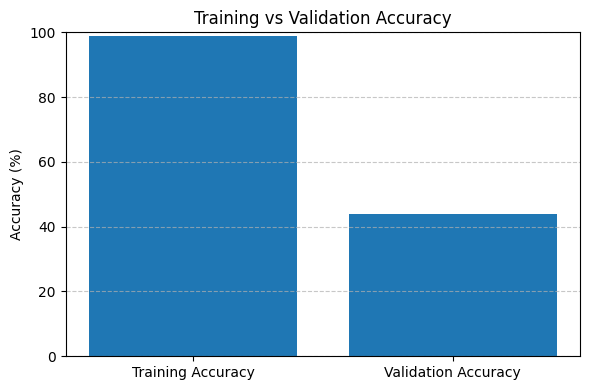

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Predictions already obtained
train_preds = final_model.predict(train_features)
valid_preds = final_model.predict(valid_features)

# Accuracy scores
train_acc = accuracy_score(train_labels, train_preds)
valid_acc = accuracy_score(valid_labels, valid_preds)

# Plotting
plt.figure(figsize=(6, 4))
plt.bar(['Training Accuracy', 'Validation Accuracy'], [train_acc * 100, valid_acc * 100])
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [7]:
import os
import numpy as np
import tensorflow as tf
import gc
import optuna
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# Paths
train_dir = r"C:\Users\PRATHESWARAN H\Desktop\Ajmal\Augumented leaf detection\train"
valid_dir = r"C:\Users\PRATHESWARAN H\Desktop\Ajmal\Augumented leaf detection\valid"

# Config
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 8
EPOCHS = 50

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_generator.class_indices)
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
train_labels = train_generator.classes

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

# Callbacks
early_stopping_cb = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)

# Build EfficientNetB3 Model
def build_single_model():
    base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.6)(x)
    out = Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs=base_model.input, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=EPOCHS,
        callbacks=[early_stopping_cb, reduce_lr],
        class_weight=class_weights,
        verbose=1
    )

    return model

# Train Model & Extract Features
model = build_single_model()
feature_model = Model(inputs=model.input, outputs=model.layers[-3].output)
train_features = feature_model.predict(train_generator, verbose=1)
valid_features = feature_model.predict(valid_generator, verbose=1)

# Preprocessing
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
valid_features = scaler.transform(valid_features)

pca = PCA(n_components=100)
train_features = pca.fit_transform(train_features)
valid_features = pca.transform(valid_features)

# SMOTE and Split
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(train_features, train_labels)
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# Optuna Optimization
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42
    }

    model = LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[early_stopping(stopping_rounds=10), log_evaluation(0)]
    )

    preds = model.predict(X_val)
    return f1_score(y_val, preds, average='macro')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Train Final Model
best_params = study.best_params
best_params.update({'random_state': 42})
final_model = LGBMClassifier(**best_params)
final_model.fit(X_resampled, y_resampled)

# Evaluate
train_preds = final_model.predict(train_features)
valid_preds = final_model.predict(valid_features)

print("\n🔍 Training Report:")
print(classification_report(train_labels, train_preds, target_names=list(train_generator.class_indices.keys())))
print(f"Training Accuracy: {accuracy_score(train_labels, train_preds) * 100:.2f}%")

print("\n📊 Validation Report:")
print(classification_report(valid_generator.classes, valid_preds, target_names=list(valid_generator.class_indices.keys())))
print(f"Validation Accuracy: {accuracy_score(valid_generator.classes, valid_preds) * 100:.2f}%")

Found 17216 images belonging to 3 classes.
Found 5554 images belonging to 3 classes.
Epoch 1/50
2152/2152 [==============================] - 692s 317ms/step - loss: 1.3375 - accuracy: 0.3362 - val_loss: 1.2633 - val_accuracy: 0.2767
Epoch 2/50
2152/2152 [==============================] - 669s 311ms/step - loss: 1.1950 - accuracy: 0.3726 - val_loss: 1.1515 - val_accuracy: 0.2767
Epoch 3/50
2152/2152 [==============================] - 685s 318ms/step - loss: 1.1284 - accuracy: 0.3067 - val_loss: 1.1092 - val_accuracy: 0.2767
Epoch 4/50
2152/2152 [==============================] - 681s 316ms/step - loss: 1.1051 - accuracy: 0.2711 - val_loss: 1.0963 - val_accuracy: 0.5346
Epoch 5/50
2152/2152 [==============================] - 724s 336ms/step - loss: 1.1007 - accuracy: 0.2739 - val_loss: 1.1005 - val_accuracy: 0.1887
Epoch 6/50
2152/2152 [==============================] - 729s 339ms/step - loss: 1.0992 - accuracy: 0.2483 - val_loss: 1.0996 - val_accuracy: 0.1887
Epoch 7/50
2152/2152 [=====

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
[I 2025-04-06 16:58:31,500] A new study created in memory with name: no-name-f1e5e647-a4e5-46bf-aa5b-c8536f89269f
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:31,613] Trial 0 finished with value: 0.3456000535820662 and parameters: {'n_estimators': 135, 'max_depth': 5, 'learning_rate': 0.05144707093250666, 'num_leaves': 46, 'subsample': 0.9445822135727724, 'colsample_bytree': 0.9139832812796802}. Best is trial 0 with value: 0.3456000535820662.
C:\Users\PRATHESWARAN H\anaconda3

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 1
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:31,774] Trial 2 finished with value: 0.3554672115790877 and parameters: {'n_estimators': 264, 'max_depth': 8, 'learning_rate': 0.06941620021921058, 'num_leaves': 51, 'subsample': 0.7727096334951713, 'colsample_bytree': 0.6459552811952186}. Best is trial 2 with value: 0.3554672115790877.
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:31,857] Trial 3 finished with value: 0.3510533452959674 and parameters: {'n_estimators': 228, 'max_depth': 7, 'learning_rate': 0.07424804232428463, 'num_leaves': 93, 'subsample': 0.6010650324634176, 'colsample_bytree': 0.7035609256079608}. 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:31,934] Trial 4 finished with value: 0.33639210053066276 and parameters: {'n_estimators': 299, 'max_depth': 4, 'learning_rate': 0.05136099778267345, 'num_leaves': 99, 'subsample': 0.7263147660338584, 'colsample_bytree': 0.8597206011625863}. Best is trial 2 with value: 0.3554672115790877.
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:31,969] Trial 5 finished with value: 0.3207391817793345 and parameters: {'n_estimators': 274, 'max_depth': 3, 'learning_rate': 0.09286182609878528, 'num_leaves': 99, 'subsample': 0.6194397768648379, 'colsample_bytree': 0.9575071363049865}.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 1
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-04-06 16:58:32,136] Trial 7 finished with value: 0.3490908476591929 and parameters: {'n_estimators': 271, 'max_depth': 8, 'learning_rate': 0.060388338161242665, 'num_leaves': 28, 'subsample': 0.7630831740185153, 'colsample_bytree': 0.8600587715578436}. Best is trial 2 with value: 0.3554672115790877.
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:32,201] Trial 8 finished with value: 0.35367991863041365 and parameters: {'n_estimators': 104, 'max_depth': 8, 'learning_rate': 0.1231230606152659, 'num_leaves': 71, 'subsample': 0.7408503911579285, 'colsample_bytree': 0.7808596145659495}. Best is trial 2 with value: 0.3554672115790877.
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifie

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 1
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:32,592] Trial 10 finished with value: 0.3464260630129785 and parameters: {'n_estimators': 237, 'max_depth': 6, 'learning_rate': 0.012323443050965888, 'num_leaves': 59, 'subsample': 0.8565836672160921, 'colsample_bytree': 0.6146356595507494}. Best is trial 2 with value: 0.3554672115790877.
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:32,662] Trial 11 finished with value: 0.34663750718506364 and parameters: {'n_estimators': 192, 'max_depth': 8, 'learning_rate': 0.18683120029537573, 'num_leaves': 20, 'subsample': 0.9942942851357723, 'colsample_bytree': 0.698028134329135

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[177]	valid_0's multi_logloss: 1.09615
[LightGBM] [Info] Auto-cho

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:32,743] Trial 12 finished with value: 0.3485741988736362 and parameters: {'n_estimators': 223, 'max_depth': 7, 'learning_rate': 0.1896785011273208, 'num_leaves': 48, 'subsample': 0.8456241399512546, 'colsample_bytree': 0.7200915451148958}. Best is trial 2 with value: 0.3554672115790877.
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:32,810] Trial 13 finished with value: 0.3448606918943482 and parameters: {'n_estimators': 169, 'max_depth': 6, 'learning_rate': 0.15025737872123585, 'num_leaves': 35, 'subsample': 0.8893143590479482, 'colsample_bytree': 0.7733117896432009}.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 1
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:32,982] Trial 15 finished with value: 0.3527397152317355 and parameters: {'n_estimators': 257, 'max_depth': 7, 'learning_rate': 0.14689465810978602, 'num_leaves': 64, 'subsample': 0.8013367457822049, 'colsample_bytree': 0.6507434548119112}. Best is trial 2 with value: 0.3554672115790877.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 1
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:33,228] Trial 16 finished with value: 0.34813025687410487 and parameters: {'n_estimators': 294, 'max_depth': 6, 'learning_rate': 0.02011108301141587, 'num_leaves': 54, 'subsample': 0.672247934154416, 'colsample_bytree': 0.6028423452366016}. Best is trial 2 with value: 0.3554672115790877.
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:33,327] Trial 17 finished with value: 0.35690856454008113 and parameters: {'n_estimators': 251, 'max_depth': 8, 'learning_rate': 0.14450839343283634, 'num_leaves': 81, 'subsample': 0.8016732247206085, 'colsample_bytree': 0.6833005718939138

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 1
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:33,525] Trial 19 finished with value: 0.34799917494110816 and parameters: {'n_estimators': 211, 'max_depth': 4, 'learning_rate': 0.12625661596232313, 'num_leaves': 73, 'subsample': 0.6754866686304308, 'colsample_bytree': 0.657869162596413}. Best is trial 17 with value: 0.35690856454008113.
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:33,636] Trial 20 finished with value: 0.3538196899047256 and parameters: {'n_estimators': 280, 'max_depth': 8, 'learning_rate': 0.16569337446539892, 'num_leaves': 83, 'subsample': 0.8490879898692184, 'colsample_bytree': 0.682654292894776

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 1
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:33,744] Trial 21 finished with value: 0.3568355230454478 and parameters: {'n_estimators': 259, 'max_depth': 8, 'learning_rate': 0.15149757331175576, 'num_leaves': 65, 'subsample': 0.8111339393984681, 'colsample_bytree': 0.6749526715747117}. Best is trial 17 with value: 0.35690856454008113.
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:33,863] Trial 22 finished with value: 0.35196070471928365 and parameters: {'n_estimators': 253, 'max_depth': 7, 'learning_rate': 0.162639910134925, 'num_leaves': 67, 'subsample': 0.8172096386666349, 'colsample_bytree': 0.7319827398825122

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 1
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:34,000] Trial 23 finished with value: 0.35107876982232095 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.08511892715070887, 'num_leaves': 52, 'subsample': 0.8832577508533126, 'colsample_bytree': 0.6231469436666752}. Best is trial 17 with value: 0.35690856454008113.
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:34,103] Trial 24 finished with value: 0.34904459242140334 and parameters: {'n_estimators': 240, 'max_depth': 8, 'learning_rate': 0.13194182479938327, 'num_leaves': 89, 'subsample': 0.7740378552326815, 'colsample_bytree': 0.6858697686421

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 1
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:34,233] Trial 25 finished with value: 0.3545568502606746 and parameters: {'n_estimators': 262, 'max_depth': 7, 'learning_rate': 0.10360890533509745, 'num_leaves': 74, 'subsample': 0.9061269252553914, 'colsample_bytree': 0.8230511168076606}. Best is trial 17 with value: 0.35690856454008113.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 1
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:34,348] Trial 26 finished with value: 0.35333409097484597 and parameters: {'n_estimators': 292, 'max_depth': 6, 'learning_rate': 0.16637449344325186, 'num_leaves': 43, 'subsample': 0.8207268465682074, 'colsample_bytree': 0.7494921682347897}. Best is trial 17 with value: 0.35690856454008113.
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:34,595] Trial 27 finished with value: 0.35551313049646166 and parameters: {'n_estimators': 222, 'max_depth': 8, 'learning_rate': 0.027674440717789822, 'num_leaves': 66, 'subsample': 0.7506706255113155, 'colsample_bytree': 0.638460750128

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 1
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:34,707] Trial 28 finished with value: 0.34408460617050207 and parameters: {'n_estimators': 190, 'max_depth': 7, 'learning_rate': 0.11091019772763677, 'num_leaves': 66, 'subsample': 0.6871073691920137, 'colsample_bytree': 0.627054788012668}. Best is trial 17 with value: 0.35690856454008113.
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-06 16:58:34,811] Trial 29 finished with value: 0.3450541733426539 and parameters: {'n_estimators': 225, 'max_depth': 5, 'learning_rate': 0.13850634018622365, 'num_leaves': 77, 'subsample': 0.7463327281538706, 'colsample_bytree': 0.675003483095377

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 1
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [8]:
import os
import numpy as np
import tensorflow as tf
import gc
import joblib
import optuna
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier as XGBSklearn
from lightgbm import LGBMClassifier as LGBMSklearn, early_stopping as lgb_early_stopping
from sklearn.svm import SVC
from sklearn.base import clone  # ✅ Important fix
from tensorflow.keras.applications import EfficientNetB3, DenseNet121, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Enable GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
for gpu in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError:
        pass

# Paths
train_dir = r"C:\Users\PRATHESWARAN H\Desktop\Ajmal\Augumented leaf detection\train"
valid_dir = r"C:\Users\PRATHESWARAN H\Desktop\Ajmal\Augumented leaf detection\valid"
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 8
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

num_classes = len(train_generator.class_indices)
train_labels = train_generator.classes

# Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

# Feature Extraction
def extract_and_save_features(base_model_class, model_name, generator, save_dir="features"):
    print(f"\n🚀 Extracting features using {model_name}...")
    tf.keras.backend.clear_session()
    gc.collect()
    base_model = base_model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    model = Model(inputs=base_model.input, outputs=x)
    features = model.predict(generator, verbose=1)
    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, f"{model_name}_features.npy"), features)
    tf.keras.backend.clear_session()
    del base_model, model
    gc.collect()

# Extract Features (Training + Validation)
extract_and_save_features(EfficientNetB3, "effnet_train", train_generator)
extract_and_save_features(DenseNet121, "densenet_train", train_generator)
extract_and_save_features(InceptionV3, "inception_train", train_generator)
extract_and_save_features(EfficientNetB3, "effnet_valid", valid_generator)
extract_and_save_features(DenseNet121, "densenet_valid", valid_generator)
extract_and_save_features(InceptionV3, "inception_valid", valid_generator)

# Load Features
train_features = np.concatenate([
    np.load("features/effnet_train_features.npy"),
    np.load("features/densenet_train_features.npy"),
    np.load("features/inception_train_features.npy")
], axis=1)

valid_features = np.concatenate([
    np.load("features/effnet_valid_features.npy"),
    np.load("features/densenet_valid_features.npy"),
    np.load("features/inception_valid_features.npy")
], axis=1)

# Scale & Reduce Dimensionality
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
valid_features = scaler.transform(valid_features)

pca = PCA(n_components=150)
train_features = pca.fit_transform(train_features)
valid_features = pca.transform(valid_features)

# Labels
y_train = train_generator.classes
y_valid = valid_generator.classes
X_train, X_val, y_train_split, y_val_split = train_test_split(train_features, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Optuna Tuning Functions
def objective_lgb(trial):
    print(f"\n🔍 Tuning LightGBM - Trial {trial.number + 1}")
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42
    }
    model = LGBMSklearn(**params)
    model.fit(X_train, y_train_split, eval_set=[(X_val, y_val_split)],
              callbacks=[lgb_early_stopping(10)])
    return model.score(X_val, y_val_split)

def objective_xgb(trial):
    print(f"\n🔍 Tuning XGBoost - Trial {trial.number + 1}")
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'mlogloss'
    }
    model = XGBSklearn(**params)
    model.fit(
        X_train,
        y_train_split,
        eval_set=[(X_val, y_val_split)],
        early_stopping_rounds=10
    )
    return model.score(X_val, y_val_split)

def objective_svc(trial):
    print(f"\n🔍 Tuning SVC - Trial {trial.number + 1}")
    params = {
        'C': trial.suggest_float('C', 0.1, 100.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-5, 1.0, log=True),
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'poly']),
        'probability': True,
        'random_state': 42
    }
    model = SVC(**params)
    model.fit(X_train, y_train_split)
    return model.score(X_val, y_val_split)

# Run Optuna Tuning
def tune_model(objective_fn, n_trials=30):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_fn, n_trials=n_trials)
    return study.best_params

params_lgb = tune_model(objective_lgb)
params_xgb = tune_model(objective_xgb)
params_svc = tune_model(objective_svc)

# ✅ Use clone() to ensure sklearn-compliant models for stacking
base_models = [
    ('xgb', clone(XGBSklearn(**params_xgb))),
    ('lgb', clone(LGBMSklearn(**params_lgb))),
    ('svc', clone(SVC(**params_svc)))
]

# Meta-Model Stacking
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1
)

# Train and Evaluate Final Model
stacked_model.fit(X_train, y_train_split)
y_val_pred = stacked_model.predict(valid_features)

print("\n📊 Final Validation Report:")
print(classification_report(y_valid, y_val_pred))
print("✅ Validation Accuracy:", accuracy_score(y_valid, y_val_pred))

# Save Final Model
joblib.dump(stacked_model, "optuna_stacked_meta_model.pkl")

Found 17216 images belonging to 3 classes.
Found 5554 images belonging to 3 classes.

🚀 Extracting features using effnet_train...
2152/2152 [==============================] - 474s 220ms/step

🚀 Extracting features using densenet_train...
2152/2152 [==============================] - 462s 214ms/step

🚀 Extracting features using inception_train...
2152/2152 [==============================] - 471s 219ms/step

🚀 Extracting features using effnet_valid...
695/695 [==============================] - 105s 148ms/step

🚀 Extracting features using densenet_valid...
695/695 [==============================] - 86s 122ms/step

🚀 Extracting features using inception_valid...
695/695 [==============================] - 82s 117ms/step


[I 2025-04-07 18:56:20,288] A new study created in memory with name: no-name-19ec2be7-34e3-4bc1-b396-7d438a64ab3c
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:20,432] Trial 0 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 188, 'learning_rate': 0.07538509689723062, 'num_leaves': 26, 'max_depth': 4, 'subsample': 0.9556165453984743, 'colsample_bytree': 0.8226570410294867}. Best is trial 0 with value: 0.49477351916376305.



🔍 Tuning LightGBM - Trial 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 150
[LightGBM] [Info] Start training from score -1.416068
[LightGBM] [Info] Start training from score -0.703658
[LightGBM] [Info] Start training from score -1.337269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:20,721] Trial 1 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 148, 'learning_rate': 0.02288405371193133, 'num_leaves': 90, 'max_depth': 10, 'subsample': 0.6552077560745427, 'colsample_bytree': 0.8491332048816382}. Best is trial 0 with value: 0.49477351916376305.
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:20,862] Trial 2 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 222, 'learning_rate': 0.1400024960881418, 'num_leaves': 22, 'max_depth': 9, 'subsample': 0.9839644956563813, 'colsample_bytree': 0.841891559211857}

Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.04301

🔍 Tuning LightGBM - Trial 3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 150
[LightGBM] [Info] Start training from score -1.416068
[LightGBM] [Info] Start training from score -0.703658
[LightGBM] [Info] Start training from score -1.337269
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.04328

🔍 Tuning LightGBM - Trial 4


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:20,996] Trial 3 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 218, 'learning_rate': 0.11305957676066991, 'num_leaves': 25, 'max_depth': 8, 'subsample': 0.6630725588240519, 'colsample_bytree': 0.6590411020453649}. Best is trial 0 with value: 0.49477351916376305.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 150
[LightGBM] [Info] Start training from score -1.416068
[LightGBM] [Info] Start training from score -0.703658
[LightGBM] [Info] Start training from score -1.337269
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.04336

🔍 Tuning LightGBM - Trial 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 150
[LightGBM] [Info] Start training from score -1.416068
[LightGBM] [Info] Start training from sc

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:21,135] Trial 4 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 278, 'learning_rate': 0.13857997068170821, 'num_leaves': 29, 'max_depth': 7, 'subsample': 0.9706921544706021, 'colsample_bytree': 0.6963365374789556}. Best is trial 0 with value: 0.49477351916376305.


Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.04341

🔍 Tuning LightGBM - Trial 6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 150
[LightGBM] [Info] Start training from score -1.416068
[LightGBM] [Info] Start training from score -0.703658
[LightGBM] [Info] Start training from score -1.337269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:21,379] Trial 5 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 187, 'learning_rate': 0.06984140302859983, 'num_leaves': 100, 'max_depth': 8, 'subsample': 0.8200611068779181, 'colsample_bytree': 0.8928309727692001}. Best is trial 0 with value: 0.49477351916376305.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.04344

🔍 Tuning LightGBM - Trial 7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 150
[LightGBM] [Info] Start training from score -1.416068
[LightGBM] [Info] Start training from score -0.703658
[LightGBM] [Info] Start training from score -1.337269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:21,593] Trial 6 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 135, 'learning_rate': 0.025526406415488593, 'num_leaves': 97, 'max_depth': 7, 'subsample': 0.6801611674768465, 'colsample_bytree': 0.9642210648738135}. Best is trial 0 with value: 0.49477351916376305.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.04298

🔍 Tuning LightGBM - Trial 8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 150
[LightGBM] [Info] Start training from score -1.416068
[LightGBM] [Info] Start training from score -0.703658
[LightGBM] [Info] Start training from score -1.337269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:21,787] Trial 7 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 293, 'learning_rate': 0.09966025687398901, 'num_leaves': 100, 'max_depth': 7, 'subsample': 0.7944044110900791, 'colsample_bytree': 0.8146320705476076}. Best is trial 0 with value: 0.49477351916376305.
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:21,893] Trial 8 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 231, 'learning_rate': 0.18248979188953773, 'num_leaves': 23, 'max_depth': 3, 'subsample': 0.8576597598302294, 'colsample_bytree': 0.768786701424149

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.04365

🔍 Tuning LightGBM - Trial 9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 150
[LightGBM] [Info] Start training from score -1.416068
[LightGBM] [Info] Start training from score -0.703658
[LightGBM] [Info] Start training from score -1.337269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:22,148] Trial 9 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 236, 'learning_rate': 0.057934911009202936, 'num_leaves': 86, 'max_depth': 9, 'subsample': 0.7028200975243526, 'colsample_bytree': 0.7496832365850125}. Best is trial 0 with value: 0.49477351916376305.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[2]	valid_0's multi_logloss: 1.04312

🔍 Tuning LightGBM - Trial 11


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:22,288] Trial 10 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 108, 'learning_rate': 0.06832313832293826, 'num_leaves': 50, 'max_depth': 4, 'subsample': 0.9083594499167509, 'colsample_bytree': 0.6010398487012163}. Best is trial 0 with value: 0.49477351916376305.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 150
[LightGBM] [Info] Start training from score -1.416068
[LightGBM] [Info] Start training from score -0.703658
[LightGBM] [Info] Start training from score -1.337269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:22,445] Trial 11 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 162, 'learning_rate': 0.010548412705674887, 'num_leaves': 72, 'max_depth': 5, 'subsample': 0.7582451736017375, 'colsample_bytree': 0.8961572413552508}. Best is trial 0 with value: 0.49477351916376305.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.04289

🔍 Tuning LightGBM - Trial 13
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 150
[LightGBM] [Info] Start training from score -1.416068
[LightGBM] [Info] Start training from score -0.703658
[LightGBM] [Info] Start training from score -1.337269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:22,631] Trial 12 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 168, 'learning_rate': 0.029766221177987523, 'num_leaves': 48, 'max_depth': 5, 'subsample': 0.6013845963491201, 'colsample_bytree': 0.8710439224598164}. Best is trial 0 with value: 0.49477351916376305.



🔍 Tuning LightGBM - Trial 14
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 150
[LightGBM] [Info] Start training from score -1.416068
[LightGBM] [Info] Start training from score -0.703658
[LightGBM] [Info] Start training from score -1.337269
Training until validation scores don't improve for 10 rounds


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:22,920] Trial 13 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 137, 'learning_rate': 0.0442709779358296, 'num_leaves': 71, 'max_depth': 10, 'subsample': 0.8920627904594918, 'colsample_bytree': 0.9882977383774343}. Best is trial 0 with value: 0.49477351916376305.
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:23,075] Trial 14 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 173, 'learning_rate': 0.09706274569940711, 'num_leaves': 42, 'max_depth': 5, 'subsample': 0.7456242368183091, 'colsample_bytree': 0.93772103157375

Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.04319

🔍 Tuning LightGBM - Trial 15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 150
[LightGBM] [Info] Start training from score -1.416068
[LightGBM] [Info] Start training from score -0.703658
[LightGBM] [Info] Start training from score -1.337269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:23,198] Trial 15 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 141, 'learning_rate': 0.07503578025914662, 'num_leaves': 63, 'max_depth': 3, 'subsample': 0.62583040087439, 'colsample_bytree': 0.7787236249314884}. Best is trial 0 with value: 0.49477351916376305.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 150
[LightGBM] [Info] Start training from score -1.416068
[LightGBM] [Info] Start training from score -0.703658
[LightGBM] [Info] Start training from score -1.337269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:23,394] Trial 16 finished with value: 0.49535423925667826 and parameters: {'n_estimators': 106, 'learning_rate': 0.1995213431204646, 'num_leaves': 81, 'max_depth': 6, 'subsample': 0.9331892904976317, 'colsample_bytree': 0.8344457513178728}. Best is trial 16 with value: 0.49535423925667826.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:23,561] Trial 17 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 106, 'learning_rate': 0.19012227827860578, 'num_leaves': 78, 'max_depth': 6, 'subsample': 0.9471727093347756, 'colsample_bytree': 0.7300155485676304}. Best is trial 16 with value: 0.49535423925667826.
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:23,697] Trial 18 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 260, 'learning_rate': 0.163684154472427, 'num_leaves': 34, 'max_depth': 4, 'subsample': 0.9209324296389476, 'colsample_bytree': 0.818202119050547

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.04404

🔍 Tuning LightGBM - Trial 19
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 150
[LightGBM] [Info] Start training from score -1.416068
[LightGBM] [Info] Start training from score -0.703658
[LightGBM] [Info] Start training from score -1.337269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:23,882] Trial 19 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 193, 'learning_rate': 0.12279804265655007, 'num_leaves': 59, 'max_depth': 6, 'subsample': 0.850691488986185, 'colsample_bytree': 0.9321504383548698}. Best is trial 16 with value: 0.49535423925667826.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 150
[LightGBM] [Info] Start training from score -1.416068
[LightGBM] [Info] Start training from score -0.703658
[LightGBM] [Info] Start training from score -1.337269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:24,014] Trial 20 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 119, 'learning_rate': 0.1674957934296229, 'num_leaves': 59, 'max_depth': 4, 'subsample': 0.9888998210695621, 'colsample_bytree': 0.7031697119020388}. Best is trial 16 with value: 0.49535423925667826.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.04294

🔍 Tuning LightGBM - Trial 22
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 150
[LightGBM] [Info] Start training from score -1.416068
[LightGBM] [Info] Start training from score -0.703658
[LightGBM] [Info] Start training from score -1.337269
Training until validation scores don't improve for 10 rounds


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:24,365] Trial 21 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 153, 'learning_rate': 0.08241759685438922, 'num_leaves': 85, 'max_depth': 10, 'subsample': 0.9437468637114794, 'colsample_bytree': 0.8520981934551045}. Best is trial 16 with value: 0.49535423925667826.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[4]	valid_0's multi_logloss: 1.0433

🔍 Tuning LightGBM - Trial 23
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 150
[LightGBM] [Info] Start training from score -1.416068
[LightGBM] [Info] Start training from score -0.703658
[LightGBM] [Info] Start training from score -1.337269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:24,543] Trial 22 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 121, 'learning_rate': 0.04632594728740651, 'num_leaves': 86, 'max_depth': 6, 'subsample': 0.8826579283887169, 'colsample_bytree': 0.7961369162858513}. Best is trial 16 with value: 0.49535423925667826.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:24,819] Trial 23 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 204, 'learning_rate': 0.010180340197718962, 'num_leaves': 93, 'max_depth': 8, 'subsample': 0.7451839605534494, 'colsample_bytree': 0.8435115643450343}. Best is trial 16 with value: 0.49535423925667826.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.04294

🔍 Tuning LightGBM - Trial 25
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number o

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:24,981] Trial 24 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 100, 'learning_rate': 0.13441846042722103, 'num_leaves': 78, 'max_depth': 5, 'subsample': 0.9469166664631306, 'colsample_bytree': 0.8951415585137313}. Best is trial 16 with value: 0.49535423925667826.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:25,253] Trial 25 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 183, 'learning_rate': 0.1569177034290844, 'num_leaves': 91, 'max_depth': 9, 'subsample': 0.8065461188179094, 'colsample_bytree': 0.804138887467606}. Best is trial 16 with value: 0.49535423925667826.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.04581

🔍 Tuning LightGBM - Trial 27


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:25,384] Trial 26 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 150, 'learning_rate': 0.08817919696390715, 'num_leaves': 68, 'max_depth': 3, 'subsample': 0.8553998262696525, 'colsample_bytree': 0.8687373903687501}. Best is trial 16 with value: 0.49535423925667826.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 150
[LightGBM] [Info] Start training from score -1.416068
[LightGBM] [Info] Start training from score -0.703658
[LightGBM] [Info] Start training from score -1.337269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:25,525] Trial 27 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 123, 'learning_rate': 0.05134300312604446, 'num_leaves': 34, 'max_depth': 4, 'subsample': 0.998570259190339, 'colsample_bytree': 0.9256765633258723}. Best is trial 16 with value: 0.49535423925667826.
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:25,703] Trial 28 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 205, 'learning_rate': 0.114308941773306, 'num_leaves': 79, 'max_depth': 6, 'subsample': 0.7143844102166891, 'colsample_bytree': 0.8362110273540572


🔍 Tuning LightGBM - Trial 29
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 150
[LightGBM] [Info] Start training from score -1.416068
[LightGBM] [Info] Start training from score -0.703658
[LightGBM] [Info] Start training from score -1.337269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-07 18:56:25,933] Trial 29 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 157, 'learning_rate': 0.19957975446976384, 'num_leaves': 54, 'max_depth': 10, 'subsample': 0.9604711918898958, 'colsample_bytree': 0.7748687902399817}. Best is trial 16 with value: 0.49535423925667826.
[I 2025-04-07 18:56:25,934] A new study created in memory with name: no-name-0a5637ff-d56e-43c8-a36f-dc52ede33040


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 13772, number of used features: 150
[LightGBM] [Info] Start training from score -1.416068
[LightGBM] [Info] Start training from score -0.703658
[LightGBM] [Info] Start training from score -1.337269
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.04567

🔍 Tuning XGBoost - Trial 1
[0]	validation_0-mlogloss:1.08549


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.07482
[2]	validation_0-mlogloss:1.06796
[3]	validation_0-mlogloss:1.06270
[4]	validation_0-mlogloss:1.05832
[5]	validation_0-mlogloss:1.05551
[6]	validation_0-mlogloss:1.05334
[7]	validation_0-mlogloss:1.05083
[8]	validation_0-mlogloss:1.05039
[9]	validation_0-mlogloss:1.04943
[10]	validation_0-mlogloss:1.04890
[11]	validation_0-mlogloss:1.04942
[12]	validation_0-mlogloss:1.04926
[13]	validation_0-mlogloss:1.04828
[14]	validation_0-mlogloss:1.04831
[15]	validation_0-mlogloss:1.04815
[16]	validation_0-mlogloss:1.04872
[17]	validation_0-mlogloss:1.04865
[18]	validation_0-mlogloss:1.04982
[19]	validation_0-mlogloss:1.04973
[20]	validation_0-mlogloss:1.05034
[21]	validation_0-mlogloss:1.05124
[22]	validation_0-mlogloss:1.05147
[23]	validation_0-mlogloss:1.05215
[24]	validation_0-mlogloss:1.05277


[I 2025-04-07 18:56:28,462] Trial 0 finished with value: 0.48751451800232287 and parameters: {'n_estimators': 254, 'learning_rate': 0.16261123587036042, 'max_depth': 8, 'subsample': 0.9287627405858324, 'colsample_bytree': 0.6100565550174927, 'gamma': 3.0765610015024625}. Best is trial 0 with value: 0.48751451800232287.



🔍 Tuning XGBoost - Trial 2
[0]	validation_0-mlogloss:1.09771
[1]	validation_0-mlogloss:1.09679
[2]	validation_0-mlogloss:1.09593
[3]	validation_0-mlogloss:1.09507


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mlogloss:1.09421
[5]	validation_0-mlogloss:1.09338
[6]	validation_0-mlogloss:1.09255
[7]	validation_0-mlogloss:1.09175
[8]	validation_0-mlogloss:1.09097
[9]	validation_0-mlogloss:1.09020
[10]	validation_0-mlogloss:1.08944
[11]	validation_0-mlogloss:1.08868
[12]	validation_0-mlogloss:1.08794
[13]	validation_0-mlogloss:1.08720
[14]	validation_0-mlogloss:1.08646
[15]	validation_0-mlogloss:1.08575
[16]	validation_0-mlogloss:1.08506
[17]	validation_0-mlogloss:1.08438
[18]	validation_0-mlogloss:1.08372
[19]	validation_0-mlogloss:1.08303
[20]	validation_0-mlogloss:1.08238
[21]	validation_0-mlogloss:1.08174
[22]	validation_0-mlogloss:1.08112
[23]	validation_0-mlogloss:1.08051
[24]	validation_0-mlogloss:1.07990
[25]	validation_0-mlogloss:1.07932
[26]	validation_0-mlogloss:1.07870
[27]	validation_0-mlogloss:1.07813
[28]	validation_0-mlogloss:1.07757
[29]	validation_0-mlogloss:1.07705
[30]	validation_0-mlogloss:1.07653
[31]	validation_0-mlogloss:1.07599
[32]	validation_0-mlogloss

[I 2025-04-07 18:56:38,524] Trial 1 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 272, 'learning_rate': 0.010314884819635673, 'max_depth': 3, 'subsample': 0.7705362734914666, 'colsample_bytree': 0.7573989369572169, 'gamma': 1.6283159566119676}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning XGBoost - Trial 3
[0]	validation_0-mlogloss:1.08911
[1]	validation_0-mlogloss:1.08098
[2]	validation_0-mlogloss:1.07452


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-mlogloss:1.06900
[4]	validation_0-mlogloss:1.06454
[5]	validation_0-mlogloss:1.06079
[6]	validation_0-mlogloss:1.05771
[7]	validation_0-mlogloss:1.05499
[8]	validation_0-mlogloss:1.05290
[9]	validation_0-mlogloss:1.05086
[10]	validation_0-mlogloss:1.04934
[11]	validation_0-mlogloss:1.04818
[12]	validation_0-mlogloss:1.04723
[13]	validation_0-mlogloss:1.04636
[14]	validation_0-mlogloss:1.04560
[15]	validation_0-mlogloss:1.04500
[16]	validation_0-mlogloss:1.04470
[17]	validation_0-mlogloss:1.04446
[18]	validation_0-mlogloss:1.04422
[19]	validation_0-mlogloss:1.04394
[20]	validation_0-mlogloss:1.04381
[21]	validation_0-mlogloss:1.04399
[22]	validation_0-mlogloss:1.04402
[23]	validation_0-mlogloss:1.04401
[24]	validation_0-mlogloss:1.04385
[25]	validation_0-mlogloss:1.04401
[26]	validation_0-mlogloss:1.04423
[27]	validation_0-mlogloss:1.04425
[28]	validation_0-mlogloss:1.04398
[29]	validation_0-mlogloss:1.04399


[I 2025-04-07 18:56:40,167] Trial 2 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 137, 'learning_rate': 0.11344135150224137, 'max_depth': 4, 'subsample': 0.9622018774479767, 'colsample_bytree': 0.6970529442795289, 'gamma': 1.792799223385451}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning XGBoost - Trial 4
[0]	validation_0-mlogloss:1.09207


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.08643
[2]	validation_0-mlogloss:1.08176
[3]	validation_0-mlogloss:1.07735
[4]	validation_0-mlogloss:1.07406
[5]	validation_0-mlogloss:1.07164
[6]	validation_0-mlogloss:1.06880
[7]	validation_0-mlogloss:1.06610
[8]	validation_0-mlogloss:1.06378
[9]	validation_0-mlogloss:1.06150
[10]	validation_0-mlogloss:1.06000
[11]	validation_0-mlogloss:1.05839
[12]	validation_0-mlogloss:1.05753
[13]	validation_0-mlogloss:1.05617
[14]	validation_0-mlogloss:1.05510
[15]	validation_0-mlogloss:1.05387
[16]	validation_0-mlogloss:1.05281
[17]	validation_0-mlogloss:1.05271
[18]	validation_0-mlogloss:1.05228
[19]	validation_0-mlogloss:1.05191
[20]	validation_0-mlogloss:1.05165
[21]	validation_0-mlogloss:1.05153
[22]	validation_0-mlogloss:1.05105
[23]	validation_0-mlogloss:1.05049
[24]	validation_0-mlogloss:1.05075
[25]	validation_0-mlogloss:1.05059
[26]	validation_0-mlogloss:1.05090
[27]	validation_0-mlogloss:1.05015
[28]	validation_0-mlogloss:1.05006
[29]	validation_0-mlogloss:1.

[I 2025-04-07 18:56:45,945] Trial 3 finished with value: 0.4901277584204414 and parameters: {'n_estimators': 300, 'learning_rate': 0.07610904093833358, 'max_depth': 10, 'subsample': 0.9373554793752595, 'colsample_bytree': 0.7184850426570011, 'gamma': 0.19422145365923238}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning XGBoost - Trial 5
[0]	validation_0-mlogloss:1.09685
[1]	validation_0-mlogloss:1.09514


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mlogloss:1.09348
[3]	validation_0-mlogloss:1.09193
[4]	validation_0-mlogloss:1.09034
[5]	validation_0-mlogloss:1.08883
[6]	validation_0-mlogloss:1.08741
[7]	validation_0-mlogloss:1.08605
[8]	validation_0-mlogloss:1.08468
[9]	validation_0-mlogloss:1.08334
[10]	validation_0-mlogloss:1.08210
[11]	validation_0-mlogloss:1.08090
[12]	validation_0-mlogloss:1.07971
[13]	validation_0-mlogloss:1.07848
[14]	validation_0-mlogloss:1.07730
[15]	validation_0-mlogloss:1.07617
[16]	validation_0-mlogloss:1.07508
[17]	validation_0-mlogloss:1.07405
[18]	validation_0-mlogloss:1.07308
[19]	validation_0-mlogloss:1.07210
[20]	validation_0-mlogloss:1.07118
[21]	validation_0-mlogloss:1.07028
[22]	validation_0-mlogloss:1.06949
[23]	validation_0-mlogloss:1.06869
[24]	validation_0-mlogloss:1.06784
[25]	validation_0-mlogloss:1.06705
[26]	validation_0-mlogloss:1.06628
[27]	validation_0-mlogloss:1.06551
[28]	validation_0-mlogloss:1.06477
[29]	validation_0-mlogloss:1.06417
[30]	validation_0-mlogloss:1

[I 2025-04-07 18:56:56,465] Trial 4 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 255, 'learning_rate': 0.020108363899832865, 'max_depth': 6, 'subsample': 0.8990693194122483, 'colsample_bytree': 0.7501035981189484, 'gamma': 4.366385633695425}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning XGBoost - Trial 6
[0]	validation_0-mlogloss:1.08305
[1]	validation_0-mlogloss:1.07197


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mlogloss:1.06424
[3]	validation_0-mlogloss:1.05889
[4]	validation_0-mlogloss:1.05510
[5]	validation_0-mlogloss:1.05224
[6]	validation_0-mlogloss:1.05083
[7]	validation_0-mlogloss:1.04983
[8]	validation_0-mlogloss:1.04886
[9]	validation_0-mlogloss:1.04883
[10]	validation_0-mlogloss:1.04846
[11]	validation_0-mlogloss:1.04848
[12]	validation_0-mlogloss:1.04855
[13]	validation_0-mlogloss:1.04826
[14]	validation_0-mlogloss:1.04737
[15]	validation_0-mlogloss:1.04789
[16]	validation_0-mlogloss:1.04809
[17]	validation_0-mlogloss:1.04815
[18]	validation_0-mlogloss:1.04913
[19]	validation_0-mlogloss:1.04909
[20]	validation_0-mlogloss:1.04966
[21]	validation_0-mlogloss:1.05040
[22]	validation_0-mlogloss:1.05051
[23]	validation_0-mlogloss:1.05008


[I 2025-04-07 18:56:58,003] Trial 5 finished with value: 0.49332171893147503 and parameters: {'n_estimators': 273, 'learning_rate': 0.1856900329115683, 'max_depth': 5, 'subsample': 0.8361117250922405, 'colsample_bytree': 0.6975498294129892, 'gamma': 4.608298913501715}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning XGBoost - Trial 7
[0]	validation_0-mlogloss:1.09443


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.09068
[2]	validation_0-mlogloss:1.08727
[3]	validation_0-mlogloss:1.08396
[4]	validation_0-mlogloss:1.08109
[5]	validation_0-mlogloss:1.07828
[6]	validation_0-mlogloss:1.07569
[7]	validation_0-mlogloss:1.07353
[8]	validation_0-mlogloss:1.07144
[9]	validation_0-mlogloss:1.06929
[10]	validation_0-mlogloss:1.06726
[11]	validation_0-mlogloss:1.06560
[12]	validation_0-mlogloss:1.06402
[13]	validation_0-mlogloss:1.06241
[14]	validation_0-mlogloss:1.06100
[15]	validation_0-mlogloss:1.05969
[16]	validation_0-mlogloss:1.05859
[17]	validation_0-mlogloss:1.05756
[18]	validation_0-mlogloss:1.05671
[19]	validation_0-mlogloss:1.05588
[20]	validation_0-mlogloss:1.05490
[21]	validation_0-mlogloss:1.05407
[22]	validation_0-mlogloss:1.05326
[23]	validation_0-mlogloss:1.05257
[24]	validation_0-mlogloss:1.05197
[25]	validation_0-mlogloss:1.05145
[26]	validation_0-mlogloss:1.05104
[27]	validation_0-mlogloss:1.05060
[28]	validation_0-mlogloss:1.05027
[29]	validation_0-mlogloss:1.

[I 2025-04-07 18:57:04,228] Trial 6 finished with value: 0.49535423925667826 and parameters: {'n_estimators': 259, 'learning_rate': 0.04637922650940053, 'max_depth': 6, 'subsample': 0.7739429250423213, 'colsample_bytree': 0.9517590551964897, 'gamma': 4.823982050895927}. Best is trial 6 with value: 0.49535423925667826.



🔍 Tuning XGBoost - Trial 8
[0]	validation_0-mlogloss:1.08666


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.07717
[2]	validation_0-mlogloss:1.07017
[3]	validation_0-mlogloss:1.06558
[4]	validation_0-mlogloss:1.06229
[5]	validation_0-mlogloss:1.05972
[6]	validation_0-mlogloss:1.05763
[7]	validation_0-mlogloss:1.05563
[8]	validation_0-mlogloss:1.05485
[9]	validation_0-mlogloss:1.05387
[10]	validation_0-mlogloss:1.05335
[11]	validation_0-mlogloss:1.05264
[12]	validation_0-mlogloss:1.05351
[13]	validation_0-mlogloss:1.05469
[14]	validation_0-mlogloss:1.05527
[15]	validation_0-mlogloss:1.05414
[16]	validation_0-mlogloss:1.05456
[17]	validation_0-mlogloss:1.05495
[18]	validation_0-mlogloss:1.05611
[19]	validation_0-mlogloss:1.05582
[20]	validation_0-mlogloss:1.05659
[21]	validation_0-mlogloss:1.05743


[I 2025-04-07 18:57:06,631] Trial 7 finished with value: 0.4811265969802555 and parameters: {'n_estimators': 245, 'learning_rate': 0.1428520271813727, 'max_depth': 9, 'subsample': 0.7747556032069538, 'colsample_bytree': 0.7170893734582013, 'gamma': 1.7943767840506446}. Best is trial 6 with value: 0.49535423925667826.



🔍 Tuning XGBoost - Trial 9
[0]	validation_0-mlogloss:1.08373


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.07366
[2]	validation_0-mlogloss:1.06601
[3]	validation_0-mlogloss:1.06147
[4]	validation_0-mlogloss:1.05784
[5]	validation_0-mlogloss:1.05506
[6]	validation_0-mlogloss:1.05387
[7]	validation_0-mlogloss:1.05309
[8]	validation_0-mlogloss:1.05289
[9]	validation_0-mlogloss:1.05156
[10]	validation_0-mlogloss:1.05221
[11]	validation_0-mlogloss:1.05148
[12]	validation_0-mlogloss:1.05154
[13]	validation_0-mlogloss:1.05146
[14]	validation_0-mlogloss:1.05149
[15]	validation_0-mlogloss:1.05114
[16]	validation_0-mlogloss:1.05137
[17]	validation_0-mlogloss:1.05159
[18]	validation_0-mlogloss:1.05189
[19]	validation_0-mlogloss:1.05231
[20]	validation_0-mlogloss:1.05319
[21]	validation_0-mlogloss:1.05368
[22]	validation_0-mlogloss:1.05497
[23]	validation_0-mlogloss:1.05585
[24]	validation_0-mlogloss:1.05600


[I 2025-04-07 18:57:08,917] Trial 8 finished with value: 0.4915795586527294 and parameters: {'n_estimators': 142, 'learning_rate': 0.17982608732246094, 'max_depth': 6, 'subsample': 0.7657467769908439, 'colsample_bytree': 0.9261824962089696, 'gamma': 1.5263546784534066}. Best is trial 6 with value: 0.49535423925667826.



🔍 Tuning XGBoost - Trial 10
[0]	validation_0-mlogloss:1.08799


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.07898
[2]	validation_0-mlogloss:1.07222
[3]	validation_0-mlogloss:1.06748
[4]	validation_0-mlogloss:1.06414
[5]	validation_0-mlogloss:1.06091
[6]	validation_0-mlogloss:1.05848
[7]	validation_0-mlogloss:1.05652
[8]	validation_0-mlogloss:1.05540
[9]	validation_0-mlogloss:1.05478
[10]	validation_0-mlogloss:1.05380
[11]	validation_0-mlogloss:1.05319
[12]	validation_0-mlogloss:1.05280
[13]	validation_0-mlogloss:1.05290
[14]	validation_0-mlogloss:1.05307
[15]	validation_0-mlogloss:1.05317
[16]	validation_0-mlogloss:1.05320
[17]	validation_0-mlogloss:1.05383
[18]	validation_0-mlogloss:1.05605
[19]	validation_0-mlogloss:1.05633
[20]	validation_0-mlogloss:1.05757
[21]	validation_0-mlogloss:1.05849
[22]	validation_0-mlogloss:1.05841


[I 2025-04-07 18:57:12,013] Trial 9 finished with value: 0.4889663182346109 and parameters: {'n_estimators': 115, 'learning_rate': 0.13143433438160904, 'max_depth': 9, 'subsample': 0.8333541047797819, 'colsample_bytree': 0.8883905887150962, 'gamma': 0.2820953127470427}. Best is trial 6 with value: 0.49535423925667826.



🔍 Tuning XGBoost - Trial 11
[0]	validation_0-mlogloss:1.09330


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.08846
[2]	validation_0-mlogloss:1.08413
[3]	validation_0-mlogloss:1.07999
[4]	validation_0-mlogloss:1.07672
[5]	validation_0-mlogloss:1.07377
[6]	validation_0-mlogloss:1.07092
[7]	validation_0-mlogloss:1.06848
[8]	validation_0-mlogloss:1.06599
[9]	validation_0-mlogloss:1.06430
[10]	validation_0-mlogloss:1.06277
[11]	validation_0-mlogloss:1.06104
[12]	validation_0-mlogloss:1.06016
[13]	validation_0-mlogloss:1.05876
[14]	validation_0-mlogloss:1.05735
[15]	validation_0-mlogloss:1.05634
[16]	validation_0-mlogloss:1.05566
[17]	validation_0-mlogloss:1.05496
[18]	validation_0-mlogloss:1.05448
[19]	validation_0-mlogloss:1.05399
[20]	validation_0-mlogloss:1.05351
[21]	validation_0-mlogloss:1.05297
[22]	validation_0-mlogloss:1.05274
[23]	validation_0-mlogloss:1.05224
[24]	validation_0-mlogloss:1.05198
[25]	validation_0-mlogloss:1.05189
[26]	validation_0-mlogloss:1.05186
[27]	validation_0-mlogloss:1.05181
[28]	validation_0-mlogloss:1.05212
[29]	validation_0-mlogloss:1.

[I 2025-04-07 18:57:17,094] Trial 10 finished with value: 0.49535423925667826 and parameters: {'n_estimators': 202, 'learning_rate': 0.06514692981171474, 'max_depth': 7, 'subsample': 0.6349473029080372, 'colsample_bytree': 0.9995244430678385, 'gamma': 3.5689359854811933}. Best is trial 6 with value: 0.49535423925667826.



🔍 Tuning XGBoost - Trial 12
[0]	validation_0-mlogloss:1.09317


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.08850
[2]	validation_0-mlogloss:1.08412
[3]	validation_0-mlogloss:1.08016
[4]	validation_0-mlogloss:1.07709
[5]	validation_0-mlogloss:1.07396
[6]	validation_0-mlogloss:1.07117
[7]	validation_0-mlogloss:1.06866
[8]	validation_0-mlogloss:1.06648
[9]	validation_0-mlogloss:1.06444
[10]	validation_0-mlogloss:1.06257
[11]	validation_0-mlogloss:1.06069
[12]	validation_0-mlogloss:1.05941
[13]	validation_0-mlogloss:1.05793
[14]	validation_0-mlogloss:1.05669
[15]	validation_0-mlogloss:1.05558
[16]	validation_0-mlogloss:1.05448
[17]	validation_0-mlogloss:1.05378
[18]	validation_0-mlogloss:1.05277
[19]	validation_0-mlogloss:1.05222
[20]	validation_0-mlogloss:1.05172
[21]	validation_0-mlogloss:1.05131
[22]	validation_0-mlogloss:1.05076
[23]	validation_0-mlogloss:1.05035
[24]	validation_0-mlogloss:1.04981
[25]	validation_0-mlogloss:1.04963
[26]	validation_0-mlogloss:1.04947
[27]	validation_0-mlogloss:1.04926
[28]	validation_0-mlogloss:1.04936
[29]	validation_0-mlogloss:1.

[I 2025-04-07 18:57:22,632] Trial 11 finished with value: 0.49332171893147503 and parameters: {'n_estimators': 202, 'learning_rate': 0.062181705912503535, 'max_depth': 7, 'subsample': 0.6220527711711227, 'colsample_bytree': 0.9802152354286106, 'gamma': 3.6701121936065677}. Best is trial 6 with value: 0.49535423925667826.



🔍 Tuning XGBoost - Trial 13
[0]	validation_0-mlogloss:1.09440


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.09025
[2]	validation_0-mlogloss:1.08637
[3]	validation_0-mlogloss:1.08264
[4]	validation_0-mlogloss:1.07958
[5]	validation_0-mlogloss:1.07663
[6]	validation_0-mlogloss:1.07386
[7]	validation_0-mlogloss:1.07137
[8]	validation_0-mlogloss:1.06916
[9]	validation_0-mlogloss:1.06737
[10]	validation_0-mlogloss:1.06550
[11]	validation_0-mlogloss:1.06374
[12]	validation_0-mlogloss:1.06226
[13]	validation_0-mlogloss:1.06096
[14]	validation_0-mlogloss:1.05934
[15]	validation_0-mlogloss:1.05800
[16]	validation_0-mlogloss:1.05713
[17]	validation_0-mlogloss:1.05610
[18]	validation_0-mlogloss:1.05526
[19]	validation_0-mlogloss:1.05446
[20]	validation_0-mlogloss:1.05360
[21]	validation_0-mlogloss:1.05293
[22]	validation_0-mlogloss:1.05216
[23]	validation_0-mlogloss:1.05147
[24]	validation_0-mlogloss:1.05092
[25]	validation_0-mlogloss:1.05058
[26]	validation_0-mlogloss:1.05011
[27]	validation_0-mlogloss:1.05009
[28]	validation_0-mlogloss:1.04982
[29]	validation_0-mlogloss:1.

[I 2025-04-07 18:57:28,204] Trial 12 finished with value: 0.49361207897793263 and parameters: {'n_estimators': 198, 'learning_rate': 0.05384156262197083, 'max_depth': 7, 'subsample': 0.6336214428479989, 'colsample_bytree': 0.9965068204477595, 'gamma': 4.8990824871150345}. Best is trial 6 with value: 0.49535423925667826.



🔍 Tuning XGBoost - Trial 14
[0]	validation_0-mlogloss:1.09146


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.08518
[2]	validation_0-mlogloss:1.08010
[3]	validation_0-mlogloss:1.07535
[4]	validation_0-mlogloss:1.07129
[5]	validation_0-mlogloss:1.06779
[6]	validation_0-mlogloss:1.06466
[7]	validation_0-mlogloss:1.06210
[8]	validation_0-mlogloss:1.06005
[9]	validation_0-mlogloss:1.05808
[10]	validation_0-mlogloss:1.05664
[11]	validation_0-mlogloss:1.05492
[12]	validation_0-mlogloss:1.05358
[13]	validation_0-mlogloss:1.05238
[14]	validation_0-mlogloss:1.05139
[15]	validation_0-mlogloss:1.05048
[16]	validation_0-mlogloss:1.04987
[17]	validation_0-mlogloss:1.04929
[18]	validation_0-mlogloss:1.04939
[19]	validation_0-mlogloss:1.04867
[20]	validation_0-mlogloss:1.04829
[21]	validation_0-mlogloss:1.04829
[22]	validation_0-mlogloss:1.04831
[23]	validation_0-mlogloss:1.04819
[24]	validation_0-mlogloss:1.04836
[25]	validation_0-mlogloss:1.04836
[26]	validation_0-mlogloss:1.04841
[27]	validation_0-mlogloss:1.04826
[28]	validation_0-mlogloss:1.04823
[29]	validation_0-mlogloss:1.

[I 2025-04-07 18:57:31,156] Trial 13 finished with value: 0.49419279907084784 and parameters: {'n_estimators': 199, 'learning_rate': 0.08395046261919706, 'max_depth': 5, 'subsample': 0.6795283073226107, 'colsample_bytree': 0.854145728810233, 'gamma': 3.6033421241265904}. Best is trial 6 with value: 0.49535423925667826.



🔍 Tuning XGBoost - Trial 15
[0]	validation_0-mlogloss:1.09480


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.09102
[2]	validation_0-mlogloss:1.08782
[3]	validation_0-mlogloss:1.08480
[4]	validation_0-mlogloss:1.08199
[5]	validation_0-mlogloss:1.07941
[6]	validation_0-mlogloss:1.07736
[7]	validation_0-mlogloss:1.07509
[8]	validation_0-mlogloss:1.07312
[9]	validation_0-mlogloss:1.07092
[10]	validation_0-mlogloss:1.06926
[11]	validation_0-mlogloss:1.06745
[12]	validation_0-mlogloss:1.06591
[13]	validation_0-mlogloss:1.06471
[14]	validation_0-mlogloss:1.06335
[15]	validation_0-mlogloss:1.06204
[16]	validation_0-mlogloss:1.06115
[17]	validation_0-mlogloss:1.06004
[18]	validation_0-mlogloss:1.05920
[19]	validation_0-mlogloss:1.05831
[20]	validation_0-mlogloss:1.05731
[21]	validation_0-mlogloss:1.05672
[22]	validation_0-mlogloss:1.05617
[23]	validation_0-mlogloss:1.05556
[24]	validation_0-mlogloss:1.05466
[25]	validation_0-mlogloss:1.05416
[26]	validation_0-mlogloss:1.05351
[27]	validation_0-mlogloss:1.05288
[28]	validation_0-mlogloss:1.05232
[29]	validation_0-mlogloss:1.

[I 2025-04-07 18:57:37,853] Trial 14 finished with value: 0.49390243902439024 and parameters: {'n_estimators': 222, 'learning_rate': 0.045049713952792114, 'max_depth': 8, 'subsample': 0.705071504035825, 'colsample_bytree': 0.9300129263010476, 'gamma': 4.076945842249518}. Best is trial 6 with value: 0.49535423925667826.



🔍 Tuning XGBoost - Trial 16
[0]	validation_0-mlogloss:1.09076


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.08391
[2]	validation_0-mlogloss:1.07839
[3]	validation_0-mlogloss:1.07342
[4]	validation_0-mlogloss:1.06933
[5]	validation_0-mlogloss:1.06566
[6]	validation_0-mlogloss:1.06288
[7]	validation_0-mlogloss:1.06034
[8]	validation_0-mlogloss:1.05843
[9]	validation_0-mlogloss:1.05691
[10]	validation_0-mlogloss:1.05532
[11]	validation_0-mlogloss:1.05376
[12]	validation_0-mlogloss:1.05295
[13]	validation_0-mlogloss:1.05211
[14]	validation_0-mlogloss:1.05099
[15]	validation_0-mlogloss:1.05020
[16]	validation_0-mlogloss:1.04951
[17]	validation_0-mlogloss:1.04889
[18]	validation_0-mlogloss:1.04883
[19]	validation_0-mlogloss:1.04820
[20]	validation_0-mlogloss:1.04773
[21]	validation_0-mlogloss:1.04786
[22]	validation_0-mlogloss:1.04787
[23]	validation_0-mlogloss:1.04797
[24]	validation_0-mlogloss:1.04803
[25]	validation_0-mlogloss:1.04818
[26]	validation_0-mlogloss:1.04792
[27]	validation_0-mlogloss:1.04791
[28]	validation_0-mlogloss:1.04779
[29]	validation_0-mlogloss:1.

[I 2025-04-07 18:57:40,379] Trial 15 finished with value: 0.49448315911730545 and parameters: {'n_estimators': 174, 'learning_rate': 0.0936446650830215, 'max_depth': 5, 'subsample': 0.6983162302113729, 'colsample_bytree': 0.8229472721385193, 'gamma': 3.213565072796548}. Best is trial 6 with value: 0.49535423925667826.



🔍 Tuning XGBoost - Trial 17


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.09582
[1]	validation_0-mlogloss:1.09303
[2]	validation_0-mlogloss:1.09052
[3]	validation_0-mlogloss:1.08832
[4]	validation_0-mlogloss:1.08591
[5]	validation_0-mlogloss:1.08380
[6]	validation_0-mlogloss:1.08168
[7]	validation_0-mlogloss:1.07977
[8]	validation_0-mlogloss:1.07801
[9]	validation_0-mlogloss:1.07614
[10]	validation_0-mlogloss:1.07431
[11]	validation_0-mlogloss:1.07265
[12]	validation_0-mlogloss:1.07130
[13]	validation_0-mlogloss:1.06974
[14]	validation_0-mlogloss:1.06833
[15]	validation_0-mlogloss:1.06723
[16]	validation_0-mlogloss:1.06622
[17]	validation_0-mlogloss:1.06520
[18]	validation_0-mlogloss:1.06427
[19]	validation_0-mlogloss:1.06332
[20]	validation_0-mlogloss:1.06234
[21]	validation_0-mlogloss:1.06154
[22]	validation_0-mlogloss:1.06077
[23]	validation_0-mlogloss:1.05975
[24]	validation_0-mlogloss:1.05897
[25]	validation_0-mlogloss:1.05836
[26]	validation_0-mlogloss:1.05771
[27]	validation_0-mlogloss:1.05716
[28]	validation_0-mlogloss:1.0

[I 2025-04-07 18:57:46,974] Trial 16 finished with value: 0.49448315911730545 and parameters: {'n_estimators': 166, 'learning_rate': 0.03413310719073028, 'max_depth': 8, 'subsample': 0.6026322367211465, 'colsample_bytree': 0.9324027520403996, 'gamma': 2.6203252736882976}. Best is trial 6 with value: 0.49535423925667826.



🔍 Tuning XGBoost - Trial 18
[0]	validation_0-mlogloss:1.08935

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[1]	validation_0-mlogloss:1.08132
[2]	validation_0-mlogloss:1.07523
[3]	validation_0-mlogloss:1.07000
[4]	validation_0-mlogloss:1.06613
[5]	validation_0-mlogloss:1.06341
[6]	validation_0-mlogloss:1.06066
[7]	validation_0-mlogloss:1.05795
[8]	validation_0-mlogloss:1.05602
[9]	validation_0-mlogloss:1.05469
[10]	validation_0-mlogloss:1.05355
[11]	validation_0-mlogloss:1.05249
[12]	validation_0-mlogloss:1.05185
[13]	validation_0-mlogloss:1.05075
[14]	validation_0-mlogloss:1.04990
[15]	validation_0-mlogloss:1.04913
[16]	validation_0-mlogloss:1.04916
[17]	validation_0-mlogloss:1.04922
[18]	validation_0-mlogloss:1.04890
[19]	validation_0-mlogloss:1.04872
[20]	validation_0-mlogloss:1.04874
[21]	validation_0-mlogloss:1.04896
[22]	validation_0-mlogloss:1.04912
[23]	validation_0-mlogloss:1.04916
[24]	validation_0-mlogloss:1.04908
[25]	validation_0-mlogloss:1.04913
[26]	validation_0-mlogloss:1.04949
[27]	validation_0-mlogloss:1.04906
[28]	validation_0-mlogloss:1.04898
[29]	validation_0-mlogloss:1

[I 2025-04-07 18:57:49,708] Trial 17 finished with value: 0.49535423925667826 and parameters: {'n_estimators': 225, 'learning_rate': 0.1094103532957004, 'max_depth': 6, 'subsample': 0.7346927505106585, 'colsample_bytree': 0.966444576865124, 'gamma': 4.865189591851089}. Best is trial 6 with value: 0.49535423925667826.



🔍 Tuning XGBoost - Trial 19
[0]	validation_0-mlogloss:1.09259
[1]	validation_0-mlogloss:1.08728


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mlogloss:1.08262
[3]	validation_0-mlogloss:1.07845
[4]	validation_0-mlogloss:1.07472
[5]	validation_0-mlogloss:1.07136
[6]	validation_0-mlogloss:1.06836
[7]	validation_0-mlogloss:1.06569
[8]	validation_0-mlogloss:1.06344
[9]	validation_0-mlogloss:1.06116
[10]	validation_0-mlogloss:1.05930
[11]	validation_0-mlogloss:1.05753
[12]	validation_0-mlogloss:1.05613
[13]	validation_0-mlogloss:1.05480
[14]	validation_0-mlogloss:1.05352
[15]	validation_0-mlogloss:1.05251
[16]	validation_0-mlogloss:1.05149
[17]	validation_0-mlogloss:1.05057
[18]	validation_0-mlogloss:1.04989
[19]	validation_0-mlogloss:1.04922
[20]	validation_0-mlogloss:1.04864
[21]	validation_0-mlogloss:1.04828
[22]	validation_0-mlogloss:1.04783
[23]	validation_0-mlogloss:1.04730
[24]	validation_0-mlogloss:1.04691
[25]	validation_0-mlogloss:1.04649
[26]	validation_0-mlogloss:1.04618
[27]	validation_0-mlogloss:1.04593
[28]	validation_0-mlogloss:1.04572
[29]	validation_0-mlogloss:1.04546
[30]	validation_0-mlogloss:1

[I 2025-04-07 18:57:52,258] Trial 18 finished with value: 0.49419279907084784 and parameters: {'n_estimators': 296, 'learning_rate': 0.06932353852402368, 'max_depth': 3, 'subsample': 0.8536474027480552, 'colsample_bytree': 0.88036357939224, 'gamma': 4.000935028052987}. Best is trial 6 with value: 0.49535423925667826.



🔍 Tuning XGBoost - Trial 20
[0]	validation_0-mlogloss:1.09542


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.09261
[2]	validation_0-mlogloss:1.08991
[3]	validation_0-mlogloss:1.08735
[4]	validation_0-mlogloss:1.08485
[5]	validation_0-mlogloss:1.08266
[6]	validation_0-mlogloss:1.08056
[7]	validation_0-mlogloss:1.07842
[8]	validation_0-mlogloss:1.07668
[9]	validation_0-mlogloss:1.07470
[10]	validation_0-mlogloss:1.07322
[11]	validation_0-mlogloss:1.07163
[12]	validation_0-mlogloss:1.07034
[13]	validation_0-mlogloss:1.06877
[14]	validation_0-mlogloss:1.06722
[15]	validation_0-mlogloss:1.06597
[16]	validation_0-mlogloss:1.06457
[17]	validation_0-mlogloss:1.06367
[18]	validation_0-mlogloss:1.06295
[19]	validation_0-mlogloss:1.06192
[20]	validation_0-mlogloss:1.06089
[21]	validation_0-mlogloss:1.06009
[22]	validation_0-mlogloss:1.05932
[23]	validation_0-mlogloss:1.05848
[24]	validation_0-mlogloss:1.05777
[25]	validation_0-mlogloss:1.05709
[26]	validation_0-mlogloss:1.05653
[27]	validation_0-mlogloss:1.05607
[28]	validation_0-mlogloss:1.05551
[29]	validation_0-mlogloss:1.

[I 2025-04-07 18:57:58,310] Trial 19 finished with value: 0.49564459930313587 and parameters: {'n_estimators': 222, 'learning_rate': 0.03632883410243684, 'max_depth': 7, 'subsample': 0.6619709329700348, 'colsample_bytree': 0.9499053105094372, 'gamma': 2.8355892416706094}. Best is trial 19 with value: 0.49564459930313587.



🔍 Tuning XGBoost - Trial 21
[0]	validation_0-mlogloss:1.09567
[1]	validation_0-mlogloss:1.09292


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mlogloss:1.09045
[3]	validation_0-mlogloss:1.08806
[4]	validation_0-mlogloss:1.08571
[5]	validation_0-mlogloss:1.08354
[6]	validation_0-mlogloss:1.08153
[7]	validation_0-mlogloss:1.07960
[8]	validation_0-mlogloss:1.07783
[9]	validation_0-mlogloss:1.07607
[10]	validation_0-mlogloss:1.07441
[11]	validation_0-mlogloss:1.07278
[12]	validation_0-mlogloss:1.07132
[13]	validation_0-mlogloss:1.06979
[14]	validation_0-mlogloss:1.06845
[15]	validation_0-mlogloss:1.06716
[16]	validation_0-mlogloss:1.06589
[17]	validation_0-mlogloss:1.06471
[18]	validation_0-mlogloss:1.06378
[19]	validation_0-mlogloss:1.06270
[20]	validation_0-mlogloss:1.06175
[21]	validation_0-mlogloss:1.06089
[22]	validation_0-mlogloss:1.05998
[23]	validation_0-mlogloss:1.05911
[24]	validation_0-mlogloss:1.05834
[25]	validation_0-mlogloss:1.05766
[26]	validation_0-mlogloss:1.05687
[27]	validation_0-mlogloss:1.05622
[28]	validation_0-mlogloss:1.05563
[29]	validation_0-mlogloss:1.05511
[30]	validation_0-mlogloss:1

[I 2025-04-07 18:58:02,943] Trial 20 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 230, 'learning_rate': 0.0327256749272952, 'max_depth': 4, 'subsample': 0.6726540632589673, 'colsample_bytree': 0.8139920240849388, 'gamma': 1.026725296349037}. Best is trial 19 with value: 0.49564459930313587.



🔍 Tuning XGBoost - Trial 22
[0]	validation_0-mlogloss:1.09479


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.09160
[2]	validation_0-mlogloss:1.08841
[3]	validation_0-mlogloss:1.08561
[4]	validation_0-mlogloss:1.08308
[5]	validation_0-mlogloss:1.08040
[6]	validation_0-mlogloss:1.07798
[7]	validation_0-mlogloss:1.07561
[8]	validation_0-mlogloss:1.07373
[9]	validation_0-mlogloss:1.07192
[10]	validation_0-mlogloss:1.07013
[11]	validation_0-mlogloss:1.06823
[12]	validation_0-mlogloss:1.06680
[13]	validation_0-mlogloss:1.06522
[14]	validation_0-mlogloss:1.06379
[15]	validation_0-mlogloss:1.06264
[16]	validation_0-mlogloss:1.06137
[17]	validation_0-mlogloss:1.06056
[18]	validation_0-mlogloss:1.06004
[19]	validation_0-mlogloss:1.05909
[20]	validation_0-mlogloss:1.05828
[21]	validation_0-mlogloss:1.05755
[22]	validation_0-mlogloss:1.05697
[23]	validation_0-mlogloss:1.05622
[24]	validation_0-mlogloss:1.05553
[25]	validation_0-mlogloss:1.05499
[26]	validation_0-mlogloss:1.05470
[27]	validation_0-mlogloss:1.05444
[28]	validation_0-mlogloss:1.05390
[29]	validation_0-mlogloss:1.

[I 2025-04-07 18:58:09,119] Trial 21 finished with value: 0.49419279907084784 and parameters: {'n_estimators': 213, 'learning_rate': 0.04206777405099897, 'max_depth': 7, 'subsample': 0.6526108195363072, 'colsample_bytree': 0.9527904571579955, 'gamma': 2.6069566306025442}. Best is trial 19 with value: 0.49564459930313587.



🔍 Tuning XGBoost - Trial 23
[0]	validation_0-mlogloss:1.09371


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.08906
[2]	validation_0-mlogloss:1.08488
[3]	validation_0-mlogloss:1.08085
[4]	validation_0-mlogloss:1.07761
[5]	validation_0-mlogloss:1.07493
[6]	validation_0-mlogloss:1.07207
[7]	validation_0-mlogloss:1.06954
[8]	validation_0-mlogloss:1.06746
[9]	validation_0-mlogloss:1.06533
[10]	validation_0-mlogloss:1.06385
[11]	validation_0-mlogloss:1.06207
[12]	validation_0-mlogloss:1.06079
[13]	validation_0-mlogloss:1.05953
[14]	validation_0-mlogloss:1.05818
[15]	validation_0-mlogloss:1.05695
[16]	validation_0-mlogloss:1.05608
[17]	validation_0-mlogloss:1.05519
[18]	validation_0-mlogloss:1.05417
[19]	validation_0-mlogloss:1.05338
[20]	validation_0-mlogloss:1.05247
[21]	validation_0-mlogloss:1.05181
[22]	validation_0-mlogloss:1.05126
[23]	validation_0-mlogloss:1.05059
[24]	validation_0-mlogloss:1.04977
[25]	validation_0-mlogloss:1.04976
[26]	validation_0-mlogloss:1.04907
[27]	validation_0-mlogloss:1.04861
[28]	validation_0-mlogloss:1.04835
[29]	validation_0-mlogloss:1.

[I 2025-04-07 18:58:14,856] Trial 22 finished with value: 0.49332171893147503 and parameters: {'n_estimators': 178, 'learning_rate': 0.056969380364433525, 'max_depth': 7, 'subsample': 0.7343341237631078, 'colsample_bytree': 0.9964230315019809, 'gamma': 3.1135364146733546}. Best is trial 19 with value: 0.49564459930313587.



🔍 Tuning XGBoost - Trial 24
[0]	validation_0-mlogloss:1.09666


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.09475
[2]	validation_0-mlogloss:1.09297
[3]	validation_0-mlogloss:1.09119
[4]	validation_0-mlogloss:1.08952
[5]	validation_0-mlogloss:1.08790
[6]	validation_0-mlogloss:1.08643
[7]	validation_0-mlogloss:1.08493
[8]	validation_0-mlogloss:1.08357
[9]	validation_0-mlogloss:1.08212
[10]	validation_0-mlogloss:1.08076
[11]	validation_0-mlogloss:1.07939
[12]	validation_0-mlogloss:1.07806
[13]	validation_0-mlogloss:1.07689
[14]	validation_0-mlogloss:1.07564
[15]	validation_0-mlogloss:1.07446
[16]	validation_0-mlogloss:1.07348
[17]	validation_0-mlogloss:1.07250
[18]	validation_0-mlogloss:1.07149
[19]	validation_0-mlogloss:1.07036
[20]	validation_0-mlogloss:1.06938
[21]	validation_0-mlogloss:1.06849
[22]	validation_0-mlogloss:1.06771
[23]	validation_0-mlogloss:1.06691
[24]	validation_0-mlogloss:1.06597
[25]	validation_0-mlogloss:1.06524
[26]	validation_0-mlogloss:1.06444
[27]	validation_0-mlogloss:1.06379
[28]	validation_0-mlogloss:1.06317
[29]	validation_0-mlogloss:1.

[I 2025-04-07 18:58:24,201] Trial 23 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 272, 'learning_rate': 0.022551848457309905, 'max_depth': 6, 'subsample': 0.7242571601778625, 'colsample_bytree': 0.8992009250990821, 'gamma': 3.6546099805902834}. Best is trial 19 with value: 0.49564459930313587.



🔍 Tuning XGBoost - Trial 25


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.09065
[1]	validation_0-mlogloss:1.08472
[2]	validation_0-mlogloss:1.07896
[3]	validation_0-mlogloss:1.07449
[4]	validation_0-mlogloss:1.07101
[5]	validation_0-mlogloss:1.06825
[6]	validation_0-mlogloss:1.06524
[7]	validation_0-mlogloss:1.06258
[8]	validation_0-mlogloss:1.06095
[9]	validation_0-mlogloss:1.05933
[10]	validation_0-mlogloss:1.05770
[11]	validation_0-mlogloss:1.05646
[12]	validation_0-mlogloss:1.05592
[13]	validation_0-mlogloss:1.05538
[14]	validation_0-mlogloss:1.05467
[15]	validation_0-mlogloss:1.05404
[16]	validation_0-mlogloss:1.05356
[17]	validation_0-mlogloss:1.05366
[18]	validation_0-mlogloss:1.05432
[19]	validation_0-mlogloss:1.05385
[20]	validation_0-mlogloss:1.05390
[21]	validation_0-mlogloss:1.05317
[22]	validation_0-mlogloss:1.05323
[23]	validation_0-mlogloss:1.05329
[24]	validation_0-mlogloss:1.05385
[25]	validation_0-mlogloss:1.05400
[26]	validation_0-mlogloss:1.05408
[27]	validation_0-mlogloss:1.05423
[28]	validation_0-mlogloss:1.0

[I 2025-04-07 18:58:27,712] Trial 24 finished with value: 0.48722415795586527 and parameters: {'n_estimators': 236, 'learning_rate': 0.09085634392715868, 'max_depth': 8, 'subsample': 0.653090916150285, 'colsample_bytree': 0.9463891311046091, 'gamma': 2.333668443234517}. Best is trial 19 with value: 0.49564459930313587.



🔍 Tuning XGBoost - Trial 26


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.09372
[1]	validation_0-mlogloss:1.08976
[2]	validation_0-mlogloss:1.08588
[3]	validation_0-mlogloss:1.08217
[4]	validation_0-mlogloss:1.07929
[5]	validation_0-mlogloss:1.07676
[6]	validation_0-mlogloss:1.07448
[7]	validation_0-mlogloss:1.07223
[8]	validation_0-mlogloss:1.07052
[9]	validation_0-mlogloss:1.06871
[10]	validation_0-mlogloss:1.06705
[11]	validation_0-mlogloss:1.06522
[12]	validation_0-mlogloss:1.06328
[13]	validation_0-mlogloss:1.06199
[14]	validation_0-mlogloss:1.06037
[15]	validation_0-mlogloss:1.05906
[16]	validation_0-mlogloss:1.05807
[17]	validation_0-mlogloss:1.05753
[18]	validation_0-mlogloss:1.05691
[19]	validation_0-mlogloss:1.05578
[20]	validation_0-mlogloss:1.05507
[21]	validation_0-mlogloss:1.05412
[22]	validation_0-mlogloss:1.05329
[23]	validation_0-mlogloss:1.05273
[24]	validation_0-mlogloss:1.05244
[25]	validation_0-mlogloss:1.05204
[26]	validation_0-mlogloss:1.05185
[27]	validation_0-mlogloss:1.05145
[28]	validation_0-mlogloss:1.0

[I 2025-04-07 18:58:34,459] Trial 25 finished with value: 0.49390243902439024 and parameters: {'n_estimators': 188, 'learning_rate': 0.05257539263943578, 'max_depth': 9, 'subsample': 0.8041033467577398, 'colsample_bytree': 0.8617283462655453, 'gamma': 4.192343104463525}. Best is trial 19 with value: 0.49564459930313587.



🔍 Tuning XGBoost - Trial 27


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.09282
[1]	validation_0-mlogloss:1.08773
[2]	validation_0-mlogloss:1.08304
[3]	validation_0-mlogloss:1.07927
[4]	validation_0-mlogloss:1.07587
[5]	validation_0-mlogloss:1.07251
[6]	validation_0-mlogloss:1.06960
[7]	validation_0-mlogloss:1.06700
[8]	validation_0-mlogloss:1.06493
[9]	validation_0-mlogloss:1.06271
[10]	validation_0-mlogloss:1.06140
[11]	validation_0-mlogloss:1.05973
[12]	validation_0-mlogloss:1.05863
[13]	validation_0-mlogloss:1.05685
[14]	validation_0-mlogloss:1.05584
[15]	validation_0-mlogloss:1.05510
[16]	validation_0-mlogloss:1.05463
[17]	validation_0-mlogloss:1.05439
[18]	validation_0-mlogloss:1.05407
[19]	validation_0-mlogloss:1.05317
[20]	validation_0-mlogloss:1.05253
[21]	validation_0-mlogloss:1.05257
[22]	validation_0-mlogloss:1.05208
[23]	validation_0-mlogloss:1.05155
[24]	validation_0-mlogloss:1.05169
[25]	validation_0-mlogloss:1.05142
[26]	validation_0-mlogloss:1.05114
[27]	validation_0-mlogloss:1.05083
[28]	validation_0-mlogloss:1.0

[I 2025-04-07 18:58:38,823] Trial 26 finished with value: 0.49361207897793263 and parameters: {'n_estimators': 257, 'learning_rate': 0.06923938067292827, 'max_depth': 7, 'subsample': 0.6067845206800727, 'colsample_bytree': 0.9203966730728825, 'gamma': 2.368438138767108}. Best is trial 19 with value: 0.49564459930313587.



🔍 Tuning XGBoost - Trial 28
[0]	validation_0-mlogloss:1.09588


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.09337
[2]	validation_0-mlogloss:1.09098
[3]	validation_0-mlogloss:1.08867
[4]	validation_0-mlogloss:1.08643
[5]	validation_0-mlogloss:1.08443
[6]	validation_0-mlogloss:1.08253
[7]	validation_0-mlogloss:1.08056
[8]	validation_0-mlogloss:1.07889
[9]	validation_0-mlogloss:1.07720
[10]	validation_0-mlogloss:1.07555
[11]	validation_0-mlogloss:1.07395
[12]	validation_0-mlogloss:1.07249
[13]	validation_0-mlogloss:1.07108
[14]	validation_0-mlogloss:1.06958
[15]	validation_0-mlogloss:1.06829
[16]	validation_0-mlogloss:1.06718
[17]	validation_0-mlogloss:1.06609
[18]	validation_0-mlogloss:1.06509
[19]	validation_0-mlogloss:1.06402
[20]	validation_0-mlogloss:1.06294
[21]	validation_0-mlogloss:1.06211
[22]	validation_0-mlogloss:1.06127
[23]	validation_0-mlogloss:1.06036
[24]	validation_0-mlogloss:1.05956
[25]	validation_0-mlogloss:1.05882
[26]	validation_0-mlogloss:1.05806
[27]	validation_0-mlogloss:1.05745
[28]	validation_0-mlogloss:1.05688
[29]	validation_0-mlogloss:1.

[I 2025-04-07 18:58:45,182] Trial 27 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 212, 'learning_rate': 0.030861725517250742, 'max_depth': 5, 'subsample': 0.6615719523566704, 'colsample_bytree': 0.967700537055536, 'gamma': 2.8974624389509382}. Best is trial 19 with value: 0.49564459930313587.



🔍 Tuning XGBoost - Trial 29
[0]	validation_0-mlogloss:1.09447


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.09073
[2]	validation_0-mlogloss:1.08745
[3]	validation_0-mlogloss:1.08419
[4]	validation_0-mlogloss:1.08139
[5]	validation_0-mlogloss:1.07879
[6]	validation_0-mlogloss:1.07641
[7]	validation_0-mlogloss:1.07394
[8]	validation_0-mlogloss:1.07172
[9]	validation_0-mlogloss:1.06969
[10]	validation_0-mlogloss:1.06790
[11]	validation_0-mlogloss:1.06616
[12]	validation_0-mlogloss:1.06458
[13]	validation_0-mlogloss:1.06296
[14]	validation_0-mlogloss:1.06170
[15]	validation_0-mlogloss:1.06030
[16]	validation_0-mlogloss:1.05909
[17]	validation_0-mlogloss:1.05782
[18]	validation_0-mlogloss:1.05670
[19]	validation_0-mlogloss:1.05583
[20]	validation_0-mlogloss:1.05501
[21]	validation_0-mlogloss:1.05426
[22]	validation_0-mlogloss:1.05353
[23]	validation_0-mlogloss:1.05277
[24]	validation_0-mlogloss:1.05210
[25]	validation_0-mlogloss:1.05141
[26]	validation_0-mlogloss:1.05087
[27]	validation_0-mlogloss:1.05030
[28]	validation_0-mlogloss:1.04987
[29]	validation_0-mlogloss:1.

[I 2025-04-07 18:58:50,610] Trial 28 finished with value: 0.49419279907084784 and parameters: {'n_estimators': 155, 'learning_rate': 0.04559361782678516, 'max_depth': 6, 'subsample': 0.8752759670842053, 'colsample_bytree': 0.8457718788297724, 'gamma': 3.4583909882573587}. Best is trial 19 with value: 0.49564459930313587.



🔍 Tuning XGBoost - Trial 30
[0]	validation_0-mlogloss:1.09726


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.09600
[2]	validation_0-mlogloss:1.09483
[3]	validation_0-mlogloss:1.09367
[4]	validation_0-mlogloss:1.09240
[5]	validation_0-mlogloss:1.09107
[6]	validation_0-mlogloss:1.08999
[7]	validation_0-mlogloss:1.08892
[8]	validation_0-mlogloss:1.08796
[9]	validation_0-mlogloss:1.08696
[10]	validation_0-mlogloss:1.08607
[11]	validation_0-mlogloss:1.08503
[12]	validation_0-mlogloss:1.08408
[13]	validation_0-mlogloss:1.08330
[14]	validation_0-mlogloss:1.08239
[15]	validation_0-mlogloss:1.08142
[16]	validation_0-mlogloss:1.08051
[17]	validation_0-mlogloss:1.07969
[18]	validation_0-mlogloss:1.07891
[19]	validation_0-mlogloss:1.07810
[20]	validation_0-mlogloss:1.07728
[21]	validation_0-mlogloss:1.07643
[22]	validation_0-mlogloss:1.07574
[23]	validation_0-mlogloss:1.07493
[24]	validation_0-mlogloss:1.07417
[25]	validation_0-mlogloss:1.07344
[26]	validation_0-mlogloss:1.07273
[27]	validation_0-mlogloss:1.07205
[28]	validation_0-mlogloss:1.07141
[29]	validation_0-mlogloss:1.

[I 2025-04-07 18:59:04,235] Trial 29 finished with value: 0.49477351916376305 and parameters: {'n_estimators': 284, 'learning_rate': 0.014924993810231248, 'max_depth': 8, 'subsample': 0.7066001508027424, 'colsample_bytree': 0.6125663147960536, 'gamma': 2.066899210366641}. Best is trial 19 with value: 0.49564459930313587.
[I 2025-04-07 18:59:04,236] A new study created in memory with name: no-name-36ab9fe1-d111-42e7-92cb-439808840515



🔍 Tuning SVC - Trial 1


[I 2025-04-07 19:00:34,370] Trial 0 finished with value: 0.48722415795586527 and parameters: {'C': 0.21654345462276994, 'gamma': 0.0003864371235171585, 'kernel': 'poly'}. Best is trial 0 with value: 0.48722415795586527.



🔍 Tuning SVC - Trial 2


[I 2025-04-07 19:01:57,940] Trial 1 finished with value: 0.49477351916376305 and parameters: {'C': 0.31197840512289465, 'gamma': 6.276421067545225e-05, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 3


[I 2025-04-07 19:05:28,652] Trial 2 finished with value: 0.38443670150987225 and parameters: {'C': 2.582918224605796, 'gamma': 0.0037830150455674494, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 4


[I 2025-04-07 19:06:56,343] Trial 3 finished with value: 0.49477351916376305 and parameters: {'C': 3.9940202497070847, 'gamma': 7.886210752698976e-05, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 5


[I 2025-04-07 19:08:01,293] Trial 4 finished with value: 0.49477351916376305 and parameters: {'C': 0.18780845230217577, 'gamma': 1.4454992857185104e-05, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 6


[I 2025-04-07 19:09:36,077] Trial 5 finished with value: 0.47793263646922185 and parameters: {'C': 0.48051207909198473, 'gamma': 0.0003758260956100169, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 7


[I 2025-04-07 19:14:59,156] Trial 6 finished with value: 0.49477351916376305 and parameters: {'C': 51.69506522250408, 'gamma': 0.03608300783417661, 'kernel': 'rbf'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 8


[I 2025-04-07 19:15:57,965] Trial 7 finished with value: 0.49477351916376305 and parameters: {'C': 0.1369016254541279, 'gamma': 1.7572392337312507e-05, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 9


[I 2025-04-07 19:18:14,246] Trial 8 finished with value: 0.49477351916376305 and parameters: {'C': 0.1626602915401387, 'gamma': 0.004306183100717113, 'kernel': 'rbf'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 10


[I 2025-04-07 19:20:29,418] Trial 9 finished with value: 0.49477351916376305 and parameters: {'C': 0.28088244059173884, 'gamma': 0.003685227441549302, 'kernel': 'rbf'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 11


[I 2025-04-07 19:25:39,531] Trial 10 finished with value: 0.49477351916376305 and parameters: {'C': 1.5711017684520538, 'gamma': 0.5216833978682385, 'kernel': 'rbf'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 12


[I 2025-04-07 19:27:43,698] Trial 11 finished with value: 0.42799070847851334 and parameters: {'C': 19.44563904851643, 'gamma': 0.0001672615065671787, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 13


[I 2025-04-07 19:29:03,112] Trial 12 finished with value: 0.49419279907084784 and parameters: {'C': 8.696880672440333, 'gamma': 6.30059182669901e-05, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 14


[I 2025-04-07 19:30:21,474] Trial 13 finished with value: 0.49477351916376305 and parameters: {'C': 0.7220155617264431, 'gamma': 7.898352532586298e-05, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 15


[I 2025-04-07 19:33:25,786] Trial 14 finished with value: 0.38443670150987225 and parameters: {'C': 7.826089441251704, 'gamma': 0.0009383324638230401, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 16


[I 2025-04-07 19:34:38,062] Trial 15 finished with value: 0.49477351916376305 and parameters: {'C': 1.0387521403821163, 'gamma': 3.410090291570078e-05, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 17


[I 2025-04-07 19:37:36,979] Trial 16 finished with value: 0.38443670150987225 and parameters: {'C': 6.373234234770529, 'gamma': 0.03734688306949892, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 18


[I 2025-04-07 19:38:34,539] Trial 17 finished with value: 0.49477351916376305 and parameters: {'C': 2.8475642666604313, 'gamma': 1.0190023389333472e-05, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 19


[I 2025-04-07 19:42:09,469] Trial 18 finished with value: 0.4724157955865273 and parameters: {'C': 98.17567988021673, 'gamma': 0.001078804292193285, 'kernel': 'rbf'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 20


[I 2025-04-07 19:45:18,700] Trial 19 finished with value: 0.38443670150987225 and parameters: {'C': 19.766583603263168, 'gamma': 0.023212354078053193, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 21


[I 2025-04-07 19:46:39,428] Trial 20 finished with value: 0.4930313588850174 and parameters: {'C': 1.5087332496705348, 'gamma': 0.0001479857990592127, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 22


[I 2025-04-07 19:47:40,407] Trial 21 finished with value: 0.49477351916376305 and parameters: {'C': 0.4049184742894685, 'gamma': 2.3956197283220446e-05, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 23


[I 2025-04-07 19:48:48,954] Trial 22 finished with value: 0.49477351916376305 and parameters: {'C': 0.12471969361707673, 'gamma': 5.50089699741029e-05, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 24


[I 2025-04-07 19:49:43,122] Trial 23 finished with value: 0.49477351916376305 and parameters: {'C': 0.7172627970425379, 'gamma': 1.0822247870526834e-05, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 25


[I 2025-04-07 19:51:16,007] Trial 24 finished with value: 0.4796747967479675 and parameters: {'C': 4.935848184002215, 'gamma': 0.00016811792146874117, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 26


[I 2025-04-07 19:52:13,931] Trial 25 finished with value: 0.49477351916376305 and parameters: {'C': 0.10357910045208608, 'gamma': 2.8641276079541114e-05, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 27


[I 2025-04-07 19:54:11,384] Trial 26 finished with value: 0.49477351916376305 and parameters: {'C': 0.2810701383557514, 'gamma': 0.0005601351039290073, 'kernel': 'rbf'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 28


[I 2025-04-07 19:55:25,635] Trial 27 finished with value: 0.49477351916376305 and parameters: {'C': 0.4230144147013482, 'gamma': 0.00010181894943694868, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 29


[I 2025-04-07 19:58:22,897] Trial 28 finished with value: 0.38443670150987225 and parameters: {'C': 18.108286652623516, 'gamma': 0.01016930208341398, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.



🔍 Tuning SVC - Trial 30


[I 2025-04-07 19:59:43,833] Trial 29 finished with value: 0.491869918699187 and parameters: {'C': 0.2490774775567353, 'gamma': 0.0003068284178984248, 'kernel': 'poly'}. Best is trial 1 with value: 0.49477351916376305.


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [1]:
import os
import numpy as np
import tensorflow as tf
import gc
import optuna
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# Paths
train_dir = r"C:\Users\PRATHESWARAN H\Desktop\Ajmal\Augumented leaf detection\train"
valid_dir = r"C:\Users\PRATHESWARAN H\Desktop\Ajmal\Augumented leaf detection\valid"

# Config
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 8
EPOCHS = 25

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode="categorical", shuffle=True)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode="categorical", shuffle=False)

num_classes = len(train_generator.class_indices)
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
train_labels = train_generator.classes

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

early_stopping_cb = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)

# Fine-tuned EfficientNetB3 model
def build_fine_tuned_model():
    base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base_model.layers[:200]:
        layer.trainable = False
    for layer in base_model.layers[200:]:
        layer.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.6)(x)
    out = Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs=base_model.input, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_generator, validation_data=valid_generator, epochs=EPOCHS,
              callbacks=[early_stopping_cb, reduce_lr], class_weight=class_weights, verbose=1)

    return model

# Train model and extract features
model = build_fine_tuned_model()
feature_model = Model(inputs=model.input, outputs=model.layers[-3].output)
train_features = feature_model.predict(train_generator, verbose=1)
valid_features = feature_model.predict(valid_generator, verbose=1)

# Preprocessing
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
valid_features = scaler.transform(valid_features)

# Optional: skip PCA to retain all features
# from sklearn.decomposition import PCA
# pca = PCA(n_components=100)
# train_features = pca.fit_transform(train_features)
# valid_features = pca.transform(valid_features)

# Apply SMOTE
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(train_features, train_labels)
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# Optuna objective
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42
    }
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              callbacks=[early_stopping(stopping_rounds=10), log_evaluation(0)])
    preds = model.predict(X_val)
    return f1_score(y_val, preds, average='macro')

# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Train final model
best_params = study.best_params
best_params.update({'random_state': 42})
final_model = LGBMClassifier(**best_params)
final_model.fit(X_resampled, y_resampled)

# Evaluate
train_preds = final_model.predict(train_features)
valid_preds = final_model.predict(valid_features)

print("\n🔍 Training Report:")
print(classification_report(train_labels, train_preds, target_names=list(train_generator.class_indices.keys())))
print(f"Training Accuracy: {accuracy_score(train_labels, train_preds) * 100:.2f}%")

print("\n📊 Validation Report:")
print(classification_report(valid_generator.classes, valid_preds, target_names=list(valid_generator.class_indices.keys())))
print(f"Validation Accuracy: {accuracy_score(valid_generator.classes, valid_preds) * 100:.2f}%")

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 17216 images belonging to 3 classes.
Found 5554 images belonging to 3 classes.
Epoch 1/25
2152/2152 [==============================] - 580s 262ms/step - loss: 1.1080 - accuracy: 0.3521 - val_loss: 1.1817 - val_accuracy: 0.2454
Epoch 2/25
2152/2152 [==============================] - 579s 269ms/step - loss: 1.0662 - accuracy: 0.3537 - val_loss: 1.1441 - val_accuracy: 0.2740
Epoch 3/25
2152/2152 [==============================] - 588s 273ms/step - loss: 1.0451 - accuracy: 0.3909 - val_loss: 1.2242 - val_accuracy: 0.2888
Epoch 4/25
2152/2152 [==============================] - 575s 267ms/step - loss: 1.0260 - accuracy: 0.3996 - val_loss: 1.1547 - val_accuracy: 0.2665
Epoch 5/25
2152/2152 [==============================] - 576s 268ms/step - loss: 0.9956 - accuracy: 0.4340 - val_loss: 1.3475 - val_accuracy: 0.2323
Epoch 6/25
2152/2152 [==============================] - 576s 268ms/step - loss: 0.9667 - accuracy: 0.4653 - val_loss: 1.4410 - val_accuracy: 0.2355
Epoch 7/25
2152/2152 [=====

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
[I 2025-04-09 13:52:20,582] A new study created in memory with name: no-name-342bd15e-0552-4c3f-8556-0044447b5bf5


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13248
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 55
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:21,333] Trial 0 finished with value: 0.4962906687789497 and parameters: {'n_estimators': 153, 'max_depth': 8, 'learning_rate': 0.05957912741853433, 'num_leaves': 40, 'subsample': 0.9156080049164173, 'colsample_bytree': 0.6507742959313452}. Best is trial 0 with value: 0.4962906687789497.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13248
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 55
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:21,772] Trial 1 finished with value: 0.4952032867471048 and parameters: {'n_estimators': 143, 'max_depth': 5, 'learning_rate': 0.1800278747542055, 'num_leaves': 72, 'subsample': 0.8317944696620678, 'colsample_bytree': 0.6869839788324168}. Best is trial 0 with value: 0.4962906687789497.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:22,828] Trial 2 finished with value: 0.5557820159856597 and parameters: {'n_estimators': 259, 'max_depth': 7, 'learning_rate': 0.19262148652566055, 'num_leaves': 78, 'subsample': 0.7830110695957262, 'colsample_bytree': 0.7100271476324207}. Best is trial 2 with value: 0.5557820159856597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:23,655] Trial 3 finished with value: 0.5177249048791791 and parameters: {'n_estimators': 270, 'max_depth': 5, 'learning_rate': 0.17149721253666456, 'num_leaves': 80, 'subsample': 0.8951477491384868, 'colsample_bytree': 0.8177322295141372}. Best is trial 2 with value: 0.5557820159856597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:24,292] Trial 4 finished with value: 0.5228101303982774 and parameters: {'n_estimators': 118, 'max_depth': 8, 'learning_rate': 0.13625853277166833, 'num_leaves': 46, 'subsample': 0.6358086175223358, 'colsample_bytree': 0.9733988957829186}. Best is trial 2 with value: 0.5557820159856597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:24,991] Trial 5 finished with value: 0.47198469220496725 and parameters: {'n_estimators': 283, 'max_depth': 4, 'learning_rate': 0.09262259945009299, 'num_leaves': 57, 'subsample': 0.9037952296789223, 'colsample_bytree': 0.8034452975604472}. Best is trial 2 with value: 0.5557820159856597.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13248
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 55
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:25,474] Trial 6 finished with value: 0.49139682768241383 and parameters: {'n_estimators': 122, 'max_depth': 6, 'learning_rate': 0.16725426868578455, 'num_leaves': 93, 'subsample': 0.7199173845904825, 'colsample_bytree': 0.6164310691459433}. Best is trial 2 with value: 0.5557820159856597.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13248
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 55
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:26,165] Trial 7 finished with value: 0.46506628041613535 and parameters: {'n_estimators': 262, 'max_depth': 4, 'learning_rate': 0.08845354182711583, 'num_leaves': 74, 'subsample': 0.6835691212397732, 'colsample_bytree': 0.9228027110721791}. Best is trial 2 with value: 0.5557820159856597.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13248
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 55
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:26,705] Trial 8 finished with value: 0.518608712469074 and parameters: {'n_estimators': 110, 'max_depth': 7, 'learning_rate': 0.1369127857872545, 'num_leaves': 75, 'subsample': 0.8011928959197294, 'colsample_bytree': 0.863853230971205}. Best is trial 2 with value: 0.5557820159856597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:27,372] Trial 9 finished with value: 0.5338982957994953 and parameters: {'n_estimators': 145, 'max_depth': 7, 'learning_rate': 0.1752166260972777, 'num_leaves': 85, 'subsample': 0.6654995173535356, 'colsample_bytree': 0.6961268504939825}. Best is trial 2 with value: 0.5557820159856597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:27,866] Trial 10 finished with value: 0.3812589046681709 and parameters: {'n_estimators': 230, 'max_depth': 3, 'learning_rate': 0.015338748798542079, 'num_leaves': 24, 'subsample': 0.751641499288875, 'colsample_bytree': 0.7410667950155279}. Best is trial 2 with value: 0.5557820159856597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:28,701] Trial 11 finished with value: 0.5512685013833648 and parameters: {'n_estimators': 188, 'max_depth': 7, 'learning_rate': 0.1932170089631206, 'num_leaves': 100, 'subsample': 0.9926483459669466, 'colsample_bytree': 0.7247030900950207}. Best is trial 2 with value: 0.5557820159856597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:29,577] Trial 12 finished with value: 0.5504123686960888 and parameters: {'n_estimators': 194, 'max_depth': 7, 'learning_rate': 0.19585340516724548, 'num_leaves': 100, 'subsample': 0.9926506365694931, 'colsample_bytree': 0.7491342161393096}. Best is trial 2 with value: 0.5557820159856597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:30,310] Trial 13 finished with value: 0.5223065198935312 and parameters: {'n_estimators': 201, 'max_depth': 6, 'learning_rate': 0.14053725440968073, 'num_leaves': 93, 'subsample': 0.9979057576836681, 'colsample_bytree': 0.7284572009552103}. Best is trial 2 with value: 0.5557820159856597.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13248
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 55
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:31,320] Trial 14 finished with value: 0.5583182756051723 and parameters: {'n_estimators': 235, 'max_depth': 7, 'learning_rate': 0.1988826182530566, 'num_leaves': 62, 'subsample': 0.8323525682394272, 'colsample_bytree': 0.7808859127655382}. Best is trial 14 with value: 0.5583182756051723.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:32,509] Trial 15 finished with value: 0.5650852448528586 and parameters: {'n_estimators': 241, 'max_depth': 8, 'learning_rate': 0.1504287013516556, 'num_leaves': 60, 'subsample': 0.8393551363951447, 'colsample_bytree': 0.8602338884024048}. Best is trial 15 with value: 0.5650852448528586.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13248
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 55
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:33,682] Trial 16 finished with value: 0.5649889355171189 and parameters: {'n_estimators': 231, 'max_depth': 8, 'learning_rate': 0.15074877492721214, 'num_leaves': 61, 'subsample': 0.8491851948326179, 'colsample_bytree': 0.8640833588955528}. Best is trial 15 with value: 0.5650852448528586.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13248
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 55
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:35,190] Trial 17 finished with value: 0.5721095865150575 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1264245431192296, 'num_leaves': 60, 'subsample': 0.842793386364977, 'colsample_bytree': 0.8835711952945096}. Best is trial 17 with value: 0.5721095865150575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:36,488] Trial 18 finished with value: 0.5539433370386476 and parameters: {'n_estimators': 299, 'max_depth': 8, 'learning_rate': 0.11263530453794475, 'num_leaves': 39, 'subsample': 0.9392120446719614, 'colsample_bytree': 0.9008474848107255}. Best is trial 17 with value: 0.5721095865150575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[299]	valid_0's multi_logloss: 0.948535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005078 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:37,645] Trial 19 finished with value: 0.5314043847794601 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.11447835168228351, 'num_leaves': 52, 'subsample': 0.8685249055911408, 'colsample_bytree': 0.9923156649945283}. Best is trial 17 with value: 0.5721095865150575.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13248
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 55
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:38,948] Trial 20 finished with value: 0.5442372117848926 and parameters: {'n_estimators': 245, 'max_depth': 8, 'learning_rate': 0.07236144451540318, 'num_leaves': 66, 'subsample': 0.7664965999216163, 'colsample_bytree': 0.9483418795788119}. Best is trial 17 with value: 0.5721095865150575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:39,988] Trial 21 finished with value: 0.5463749705169962 and parameters: {'n_estimators': 206, 'max_depth': 8, 'learning_rate': 0.15183840099876408, 'num_leaves': 53, 'subsample': 0.8413589657029947, 'colsample_bytree': 0.8638436595821452}. Best is trial 17 with value: 0.5721095865150575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:41,078] Trial 22 finished with value: 0.5670044984265437 and parameters: {'n_estimators': 218, 'max_depth': 8, 'learning_rate': 0.15677463461083457, 'num_leaves': 66, 'subsample': 0.8571464223877342, 'colsample_bytree': 0.8544900945753245}. Best is trial 17 with value: 0.5721095865150575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:42,124] Trial 23 finished with value: 0.5489475407427246 and parameters: {'n_estimators': 209, 'max_depth': 8, 'learning_rate': 0.12251606298361709, 'num_leaves': 67, 'subsample': 0.8130067797848146, 'colsample_bytree': 0.8378038758643618}. Best is trial 17 with value: 0.5721095865150575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:42,968] Trial 24 finished with value: 0.5518086011498889 and parameters: {'n_estimators': 170, 'max_depth': 8, 'learning_rate': 0.15616327508379774, 'num_leaves': 47, 'subsample': 0.8753733110261932, 'colsample_bytree': 0.9026643004011345}. Best is trial 17 with value: 0.5721095865150575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:43,948] Trial 25 finished with value: 0.5313790022391336 and parameters: {'n_estimators': 278, 'max_depth': 7, 'learning_rate': 0.1298908903464463, 'num_leaves': 29, 'subsample': 0.9226110300716566, 'colsample_bytree': 0.7817077141547353}. Best is trial 17 with value: 0.5721095865150575.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13248
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 55
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:44,909] Trial 26 finished with value: 0.5268806308815126 and parameters: {'n_estimators': 247, 'max_depth': 6, 'learning_rate': 0.09790392381062518, 'num_leaves': 66, 'subsample': 0.7327606831809521, 'colsample_bytree': 0.8378753994221554}. Best is trial 17 with value: 0.5721095865150575.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13248
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 55
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:45,974] Trial 27 finished with value: 0.5542948476189096 and parameters: {'n_estimators': 218, 'max_depth': 8, 'learning_rate': 0.16102465967480134, 'num_leaves': 57, 'subsample': 0.9525473351074306, 'colsample_bytree': 0.9023826405030008}. Best is trial 17 with value: 0.5721095865150575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:46,826] Trial 28 finished with value: 0.5396459352988648 and parameters: {'n_estimators': 180, 'max_depth': 7, 'learning_rate': 0.14570141052891414, 'num_leaves': 69, 'subsample': 0.8713221905329223, 'colsample_bytree': 0.9304651368060421}. Best is trial 17 with value: 0.5721095865150575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-09 13:52:47,580] Trial 29 finished with value: 0.5366229442987646 and parameters: {'n_estimators': 170, 'max_depth': 8, 'learning_rate': 0.12198771556734639, 'num_leaves': 38, 'subsample': 0.7825863038680378, 'colsample_bytree': 0.8800729211505733}. Best is trial 17 with value: 0.5721095865150575.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13363
[LightGBM] [Info] Number of data points in the train set: 25554, number of used features: 55
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🔍 Training Report:
              precision    recall  f1-score   support

   Brownspot       0.93      0.92      0.93      4178
     Healthy       0.96      0.95      0.96      8518
       Hispa       0.93      0.94      0.94      4520

    accuracy                           0.94     17216
   macro avg       0.94      0.94      0.94     17216
weighted avg       0.94      0.94      0.94     17216

Training Accuracy: 94.35%

📊 Validation Report:
              precision    recall  f1-score   support

   Brownspot       0.20      0.24      0.22      1048
     Healthy       0.52      0.48      0.50      2969
       Hispa       0.27      0.26      0.27      1537

    accuracy                           0.38      5554
   macro avg       0.33      0.33      0.33      5554
weighted avg       0.39      0.38      0.38      5554

Validation Accuracy: 37.72%


In [ ]:
import os
import numpy as np
import tensorflow as tf
import gc
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetB3, DenseNet121, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from xgboost import XGBClassifier

# Paths
train_dir = r"C:\Users\PRATHESWARAN H\Desktop\Ajmal\Augumented leaf detection\train"
valid_dir = r"C:\Users\PRATHESWARAN H\Desktop\Ajmal\Augumented leaf detection\valid"

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 8

# Data Generators
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode="categorical", shuffle=False)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode="categorical", shuffle=False)

num_classes = len(train_generator.class_indices)
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
train_labels = train_generator.classes
valid_labels = valid_generator.classes

# Feature Extraction
def extract_features(model_class, model_name, generator):
    print(f"🔍 Extracting features from {model_name}...")
    tf.keras.backend.clear_session()
    base_model = model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    feature_model = Model(inputs=base_model.input, outputs=x)
    features = feature_model.predict(generator, verbose=1)
    del feature_model
    gc.collect()
    return features

# Extract features from all three CNNs
features_effnet_train = extract_features(EfficientNetB3, "EfficientNetB3", train_generator)
features_densenet_train = extract_features(DenseNet121, "DenseNet121", train_generator)
features_inception_train = extract_features(InceptionV3, "InceptionV3", train_generator)

features_effnet_valid = extract_features(EfficientNetB3, "EfficientNetB3", valid_generator)
features_densenet_valid = extract_features(DenseNet121, "DenseNet121", valid_generator)
features_inception_valid = extract_features(InceptionV3, "InceptionV3", valid_generator)

# Concatenate features
X_train_full = np.concatenate([features_effnet_train, features_densenet_train, features_inception_train], axis=1)
X_valid_full = np.concatenate([features_effnet_valid, features_densenet_valid, features_inception_valid], axis=1)

# Scale
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_valid_full = scaler.transform(X_valid_full)

y_train = train_labels
y_valid = valid_labels

# Train/Test split for Optuna
X_train, X_val, y_train_split, y_val_split = train_test_split(X_train_full, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Optuna objective
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'tree_method': 'gpu_hist'
    }
    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='mlogloss')
    model.fit(X_train, y_train_split)
    preds = model.predict(X_val)
    return f1_score(y_val_split, preds, average='macro')

# Run Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Final model
best_params = study.best_params
best_params.update({'random_state': 42, 'use_label_encoder': False, 'eval_metric': 'mlogloss', 'tree_method': 'gpu_hist'})
final_model = XGBClassifier(**best_params)
final_model.fit(X_train_full, y_train)

# Evaluate
train_preds = final_model.predict(X_train_full)
valid_preds = final_model.predict(X_valid_full)

print("\n📈 Training Report:")
print(classification_report(y_train, train_preds, target_names=list(train_generator.class_indices.keys())))
print(f"Training Accuracy: {accuracy_score(y_train, train_preds) * 100:.2f}%")

print("\n📊 Validation Report:")
print(classification_report(y_valid, valid_preds, target_names=list(valid_generator.class_indices.keys())))
print(f"Validation Accuracy: {accuracy_score(y_valid, valid_preds) * 100:.2f}%")

Found 17216 images belonging to 3 classes.
Found 5554 images belonging to 3 classes.
🔍 Extracting features from EfficientNetB3...
2152/2152 [==============================] - 274s 127ms/step
🔍 Extracting features from DenseNet121...
2152/2152 [==============================] - 267s 123ms/step
🔍 Extracting features from InceptionV3...
2152/2152 [==============================] - 268s 124ms/step
🔍 Extracting features from EfficientNetB3...
695/695 [==============================] - 77s 109ms/step
🔍 Extracting features from DenseNet121...
695/695 [==============================] - 67s 95ms/step
🔍 Extracting features from InceptionV3...
695/695 [==============================] - 65s 93ms/step


[I 2025-04-09 14:39:53,445] A new study created in memory with name: no-name-0d4752a3-9d32-4a0f-97d5-8ddfdd6cdfe3
[I 2025-04-09 14:41:47,270] Trial 0 finished with value: 0.8151408657048771 and parameters: {'n_estimators': 122, 'max_depth': 7, 'learning_rate': 0.046107088960511945, 'subsample': 0.9070355117336725, 'colsample_bytree': 0.9594552143056287, 'gamma': 1.4153232884536748, 'reg_alpha': 0.6194438171924826, 'reg_lambda': 0.41013749036701264}. Best is trial 0 with value: 0.8151408657048771.
[I 2025-04-09 14:43:15,019] Trial 1 finished with value: 0.8202412206385663 and parameters: {'n_estimators': 283, 'max_depth': 10, 'learning_rate': 0.10703026015575297, 'subsample': 0.6350173410038895, 'colsample_bytree': 0.993204781180264, 'gamma': 3.1567040300921634, 'reg_alpha': 0.08033733982737268, 'reg_lambda': 0.4889949616858079}. Best is trial 1 with value: 0.8202412206385663.


In [1]:
!pip install tensorflow-addons

   ---------------------------------------- 0.0/729.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/729.9 kB ? eta -:--:--
   -------------- ------------------------- 262.1/729.9 kB ? eta -:--:--
   ---------------------------- ----------- 524.3/729.9 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 729.9/729.9 kB 1.1 MB/s eta 0:00:00


In [10]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import optuna

# ---- CONFIG ----
train_dir = r"C:\Users\PRATHESWARAN H\Desktop\Ajmal\Augumented leaf detection\train"
valid_dir = r"C:\Users\PRATHESWARAN H\Desktop\Ajmal\Augumented leaf detection\valid"
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 8
EPOCHS = 25

# ---- DATA AUGMENTATION ----
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode="categorical", shuffle=True)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode="categorical", shuffle=False)

num_classes = len(train_generator.class_indices)
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
train_labels = train_generator.classes

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

early_stopping_cb = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)

# ---- CUSTOM FOCAL LOSS ----
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return loss

# ---- BUILD MODEL ----
def build_fine_tuned_model():
    base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base_model.layers[:200]:
        layer.trainable = False
    for layer in base_model.layers[200:]:
        layer.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.6)(x)
    out = Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs=base_model.input, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=focal_loss(gamma=2.0, alpha=0.25),
                  metrics=['accuracy'])

    model.fit(train_generator, validation_data=valid_generator, epochs=EPOCHS,
              callbacks=[early_stopping_cb, reduce_lr], class_weight=class_weights, verbose=1)

    return model

# ---- TRAIN MODEL & EXTRACT FEATURES ----
model = build_fine_tuned_model()
feature_model = Model(inputs=model.input, outputs=model.layers[-3].output)

train_features = feature_model.predict(train_generator, verbose=1)
valid_features = feature_model.predict(valid_generator, verbose=1)

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
valid_features = scaler.transform(valid_features)

# ---- SMOTE ----
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(train_features, train_labels)

# ---- STRATIFIED SPLIT ----
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in sss.split(X_resampled, y_resampled):
    X_train, X_val = X_resampled[train_index], X_resampled[val_index]
    y_train, y_val = y_resampled[train_index], y_resampled[val_index]

# ---- OPTUNA OBJECTIVE ----
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42
    }
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              callbacks=[early_stopping(stopping_rounds=10), log_evaluation(0)])
    preds = model.predict(X_val)
    return f1_score(y_val, preds, average='macro')

# ---- RUN OPTUNA ----
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# ---- FINAL LGBM MODEL ----
best_params = study.best_params
best_params.update({'random_state': 42})
final_model = LGBMClassifier(**best_params)
final_model.fit(X_resampled, y_resampled)

# ---- EVALUATION ----
train_preds = final_model.predict(train_features)
valid_preds = final_model.predict(valid_features)

print("\n🔍 Training Report:")
print(classification_report(train_labels, train_preds, target_names=list(train_generator.class_indices.keys())))
print(f"Training Accuracy: {accuracy_score(train_labels, train_preds) * 100:.2f}%")

print("\n📊 Validation Report:")
print(classification_report(valid_generator.classes, valid_preds, target_names=list(valid_generator.class_indices.keys())))
print(f"Validation Accuracy: {accuracy_score(valid_generator.classes, valid_preds) * 100:.2f}%")

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 17216 images belonging to 3 classes.
Found 5554 images belonging to 3 classes.
Epoch 1/25
2152/2152 [==============================] - 622s 281ms/step - loss: 0.1259 - accuracy: 0.3372 - val_loss: 0.1288 - val_accuracy: 0.2013
Epoch 2/25
2152/2152 [==============================] - 608s 283ms/step - loss: 0.1183 - accuracy: 0.3556 - val_loss: 0.1239 - val_accuracy: 0.2681
Epoch 3/25
2152/2152 [==============================] - 597s 277ms/step - loss: 0.1153 - accuracy: 0.3827 - val_loss: 0.1309 - val_accuracy: 0.2555
Epoch 4/25
2152/2152 [==============================] - 609s 283ms/step - loss: 0.1120 - accuracy: 0.3865 - val_loss: 0.1463 - val_accuracy: 0.2505
Epoch 5/25
2152/2152 [==============================] - 613s 285ms/step - loss: 0.1066 - accuracy: 0.4081 - val_loss: 0.1420 - val_accuracy: 0.2911
Epoch 6/25
2152/2152 [==============================] - 599s 278ms/step - loss: 0.1041 - accuracy: 0.4380 - val_loss: 0.1665 - val_accuracy: 0.2240
Epoch 7/25
2152/2152 [=====

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
[I 2025-04-15 02:10:29,664] A new study created in memory with name: no-name-217d11a5-6bf8-474a-97ff-c8986919343a


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13181
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 60
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:30,387] Trial 0 finished with value: 0.518338379938217 and parameters: {'n_estimators': 177, 'max_depth': 7, 'learning_rate': 0.1764260724100615, 'num_leaves': 27, 'subsample': 0.9711943628247403, 'colsample_bytree': 0.7999495450042905}. Best is trial 0 with value: 0.518338379938217.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13181
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 60
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:30,879] Trial 1 finished with value: 0.47732973668175277 and parameters: {'n_estimators': 103, 'max_depth': 7, 'learning_rate': 0.06643584968130849, 'num_leaves': 69, 'subsample': 0.6333971362513847, 'colsample_bytree': 0.8601572297536741}. Best is trial 0 with value: 0.518338379938217.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13181
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 60
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:31,485] Trial 2 finished with value: 0.4314554679794747 and parameters: {'n_estimators': 298, 'max_depth': 3, 'learning_rate': 0.05963666200709955, 'num_leaves': 37, 'subsample': 0.8327327672276689, 'colsample_bytree': 0.7659281448394397}. Best is trial 0 with value: 0.518338379938217.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:31,843] Trial 3 finished with value: 0.4418067824680043 and parameters: {'n_estimators': 120, 'max_depth': 4, 'learning_rate': 0.16094487710621824, 'num_leaves': 58, 'subsample': 0.9608794999285479, 'colsample_bytree': 0.9396722255603861}. Best is trial 0 with value: 0.518338379938217.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:32,183] Trial 4 finished with value: 0.42015248183547343 and parameters: {'n_estimators': 144, 'max_depth': 3, 'learning_rate': 0.11153074411259538, 'num_leaves': 78, 'subsample': 0.859297310445961, 'colsample_bytree': 0.8561898398942589}. Best is trial 0 with value: 0.518338379938217.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13181
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 60
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:32,706] Trial 5 finished with value: 0.4498045264002782 and parameters: {'n_estimators': 212, 'max_depth': 4, 'learning_rate': 0.08445252642838844, 'num_leaves': 60, 'subsample': 0.6720908662014689, 'colsample_bytree': 0.6378947448436448}. Best is trial 0 with value: 0.518338379938217.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:33,013] Trial 6 finished with value: 0.4274050374812071 and parameters: {'n_estimators': 127, 'max_depth': 3, 'learning_rate': 0.11947181409565734, 'num_leaves': 21, 'subsample': 0.7396210519952079, 'colsample_bytree': 0.9528421063706487}. Best is trial 0 with value: 0.518338379938217.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:33,664] Trial 7 finished with value: 0.38794323655918966 and parameters: {'n_estimators': 297, 'max_depth': 3, 'learning_rate': 0.011801662413968036, 'num_leaves': 49, 'subsample': 0.9013584541424141, 'colsample_bytree': 0.9269928195441303}. Best is trial 0 with value: 0.518338379938217.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:34,310] Trial 8 finished with value: 0.49757877934930184 and parameters: {'n_estimators': 125, 'max_depth': 8, 'learning_rate': 0.06273424998876416, 'num_leaves': 66, 'subsample': 0.7275987981240092, 'colsample_bytree': 0.6878313230208913}. Best is trial 0 with value: 0.518338379938217.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:34,769] Trial 9 finished with value: 0.47787469983992564 and parameters: {'n_estimators': 137, 'max_depth': 5, 'learning_rate': 0.12054765977410278, 'num_leaves': 91, 'subsample': 0.9471716301332892, 'colsample_bytree': 0.8392556315865976}. Best is trial 0 with value: 0.518338379938217.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:35,484] Trial 10 finished with value: 0.5215891016924626 and parameters: {'n_estimators': 199, 'max_depth': 7, 'learning_rate': 0.19941104917380892, 'num_leaves': 23, 'subsample': 0.9776856390331803, 'colsample_bytree': 0.7426440278785422}. Best is trial 10 with value: 0.5215891016924626.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:36,234] Trial 11 finished with value: 0.5171069989174728 and parameters: {'n_estimators': 199, 'max_depth': 7, 'learning_rate': 0.1990464390438961, 'num_leaves': 23, 'subsample': 0.9984245716210882, 'colsample_bytree': 0.7432650938710196}. Best is trial 10 with value: 0.5215891016924626.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13181
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 60
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:37,013] Trial 12 finished with value: 0.5411992205002095 and parameters: {'n_estimators': 192, 'max_depth': 7, 'learning_rate': 0.19659487349573698, 'num_leaves': 38, 'subsample': 0.898923776464882, 'colsample_bytree': 0.7032057739374109}. Best is trial 12 with value: 0.5411992205002095.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[191]	valid_0's multi_logloss: 0.971998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13181
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 60
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:37,875] Trial 13 finished with value: 0.5280836971942661 and parameters: {'n_estimators': 243, 'max_depth': 6, 'learning_rate': 0.15476588710700864, 'num_leaves': 39, 'subsample': 0.8888184479316182, 'colsample_bytree': 0.6958560159127446}. Best is trial 12 with value: 0.5411992205002095.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:38,783] Trial 14 finished with value: 0.5315354128995479 and parameters: {'n_estimators': 256, 'max_depth': 6, 'learning_rate': 0.15034183247612365, 'num_leaves': 43, 'subsample': 0.9009938905554742, 'colsample_bytree': 0.626685098112873}. Best is trial 12 with value: 0.5411992205002095.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:39,709] Trial 15 finished with value: 0.523523919890926 and parameters: {'n_estimators': 253, 'max_depth': 6, 'learning_rate': 0.14540616974707676, 'num_leaves': 44, 'subsample': 0.7773371835336699, 'colsample_bytree': 0.6089181067079243}. Best is trial 12 with value: 0.5411992205002095.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13181
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 60
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:40,905] Trial 16 finished with value: 0.5596211563113397 and parameters: {'n_estimators': 254, 'max_depth': 8, 'learning_rate': 0.13742627221950326, 'num_leaves': 51, 'subsample': 0.8994824670681459, 'colsample_bytree': 0.6685238109644545}. Best is trial 16 with value: 0.5596211563113397.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13181
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 60
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:41,704] Trial 17 finished with value: 0.5408730373552855 and parameters: {'n_estimators': 168, 'max_depth': 8, 'learning_rate': 0.18120305990544408, 'num_leaves': 50, 'subsample': 0.8058337644639031, 'colsample_bytree': 0.676080034331911}. Best is trial 16 with value: 0.5596211563113397.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[168]	valid_0's multi_logloss: 0.968433
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13181
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 60
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:42,658] Trial 18 finished with value: 0.546294543554192 and parameters: {'n_estimators': 234, 'max_depth': 8, 'learning_rate': 0.1313719465643225, 'num_leaves': 34, 'subsample': 0.9253329725845126, 'colsample_bytree': 0.7133060084947705}. Best is trial 16 with value: 0.5596211563113397.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:43,567] Trial 19 finished with value: 0.5296122396679263 and parameters: {'n_estimators': 229, 'max_depth': 8, 'learning_rate': 0.13376382722626876, 'num_leaves': 32, 'subsample': 0.929600713161387, 'colsample_bytree': 0.6520359835126439}. Best is trial 16 with value: 0.5596211563113397.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:44,860] Trial 20 finished with value: 0.5518833443846919 and parameters: {'n_estimators': 270, 'max_depth': 8, 'learning_rate': 0.09787054501241924, 'num_leaves': 95, 'subsample': 0.8550703618056508, 'colsample_bytree': 0.7256108894199123}. Best is trial 16 with value: 0.5596211563113397.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:46,139] Trial 21 finished with value: 0.5546183183946992 and parameters: {'n_estimators': 273, 'max_depth': 8, 'learning_rate': 0.09725256269356172, 'num_leaves': 97, 'subsample': 0.8538711004698762, 'colsample_bytree': 0.729939546695474}. Best is trial 16 with value: 0.5596211563113397.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:47,492] Trial 22 finished with value: 0.5528194545798496 and parameters: {'n_estimators': 276, 'max_depth': 8, 'learning_rate': 0.09165196897988732, 'num_leaves': 99, 'subsample': 0.8322175831555558, 'colsample_bytree': 0.7874162725928369}. Best is trial 16 with value: 0.5596211563113397.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13181
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 60
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:48,822] Trial 23 finished with value: 0.5498751621335258 and parameters: {'n_estimators': 269, 'max_depth': 8, 'learning_rate': 0.09159621437942787, 'num_leaves': 84, 'subsample': 0.7964799642654833, 'colsample_bytree': 0.7925534018585096}. Best is trial 16 with value: 0.5596211563113397.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:50,003] Trial 24 finished with value: 0.5073867314010398 and parameters: {'n_estimators': 278, 'max_depth': 7, 'learning_rate': 0.04345644110192013, 'num_leaves': 99, 'subsample': 0.8450432792746277, 'colsample_bytree': 0.7733052173730358}. Best is trial 16 with value: 0.5596211563113397.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13181
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 60
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:51,438] Trial 25 finished with value: 0.5524164748828522 and parameters: {'n_estimators': 283, 'max_depth': 8, 'learning_rate': 0.10607976418526033, 'num_leaves': 86, 'subsample': 0.7506249770692361, 'colsample_bytree': 0.9967743502095165}. Best is trial 16 with value: 0.5596211563113397.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:52,269] Trial 26 finished with value: 0.4974600024698521 and parameters: {'n_estimators': 219, 'max_depth': 6, 'learning_rate': 0.08669672241792771, 'num_leaves': 77, 'subsample': 0.8203229364000283, 'colsample_bytree': 0.6684300312810199}. Best is trial 16 with value: 0.5596211563113397.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:53,065] Trial 27 finished with value: 0.48537669964234537 and parameters: {'n_estimators': 257, 'max_depth': 5, 'learning_rate': 0.07579617399340852, 'num_leaves': 99, 'subsample': 0.865596610369982, 'colsample_bytree': 0.8325470865695695}. Best is trial 16 with value: 0.5596211563113397.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:54,519] Trial 28 finished with value: 0.5293147669104853 and parameters: {'n_estimators': 287, 'max_depth': 8, 'learning_rate': 0.04175364831471876, 'num_leaves': 90, 'subsample': 0.6953918225592857, 'colsample_bytree': 0.8833315703749272}. Best is trial 16 with value: 0.5596211563113397.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13181
[LightGBM] [Info] Number of data points in the train set: 20443, number of used features: 60
[LightGBM] [Info] Start training from score -1.098514
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Info] Start training from score -1.098661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-15 02:10:55,664] Trial 29 finished with value: 0.5447984911653762 and parameters: {'n_estimators': 266, 'max_depth': 7, 'learning_rate': 0.13722717875460438, 'num_leaves': 77, 'subsample': 0.7796955563677829, 'colsample_bytree': 0.804029291238077}. Best is trial 16 with value: 0.5596211563113397.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13300
[LightGBM] [Info] Number of data points in the train set: 25554, number of used features: 61
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PRATHESWARAN H\anaconda3\envs\gpu_leaf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [5]:
import tensorflow as tf
print(tf.__version__)

2.6.0
